# Infosys Springboard Internship Programme - 2024

## Name : Keerthivasan S


<h1 align="center"> Electricity Demand and Price Forecasting </h1>
<p>
</p>
<h2> Project and data set explanations: </h2>
<p>
</p>
<li> This is a time series forecasting problem where two distinct datasets of energy and weather data are used.
The energy consumption and weather data from various cities in Spain are combined to create a multivariate time series
forecasting problem. The energy dataset contains features related to the generation of energy from different sources
like fossil fuels, wind, and coal. On the other hand, the weather dataset contains features related to various weather
metrics such as temperature, humidity, pressure, wind speed, etc. </li>
<p>
</p>
<li>The dataset includes a four-year record of weather data <a href="https://openweathermap.org/api">https://openweathermap.org/api</a>
electrical consumption, pricing, and generation data for Spain <a href="https://transparency.entsoe.eu/dashboard/show">ENTOSE website</a> . The public ENTSOE portal was used to retrieve the consumption and generation data, while
the Spanish TSO Red Electric España was used to obtain the settlement prices <a href="https://www.esios.ree.es/en/market-and-prices?date=27-03-2023#">TSO website</a>.


<h2> Methods used in this project : </h2>
<h3> 1. Machine learning : </h3>
<ul>    
<li> XGboost Regressor </li>
</ul>
<h3> 2. Deep learning/Stacked models : </h3>
<ul>    
<li> GRU </li>
<li> LSTM </li>
<li> CNN </li>
<li> CNN-LSTM </li>
<li> LSTM-Attention </li>
</ul>
<h3> 3. Hybrid methods: </h3>
<ul>    
<li> GRU-XGBoost </li>
<li> LSTM-Attention-XGBoost </li>
</ul>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install plotly
# import sys

# tensorflow-addons version depends on the tensorflow and python version of the system,
# you can find the compatibility in this link

# https://stackoverflow.com/questions/61380552/unable-to-import-tensorflow-addons
# !pip install tensorflow-addons==0.19.0
# !pip install statsmodels
# !pip install xgboost

# print(tf.__version__)
# print(sys.version)

2.17.1
3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [ ]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

In [ ]:
# loading energy data
df_energy = pd.read_csv('/content/drive/MyDrive/Keerthivasan_S_Electricity_Forecast_and_Demand_Prediction/data/energy_dataset.csv')

In [ ]:
df_energy.head()

time  generation biomass  \
0  2020-01-01 00:00:00+01:00               447.0   
1  2020-01-01 01:00:00+01:00               449.0   
2  2020-01-01 02:00:00+01:00               448.0   
3  2020-01-01 03:00:00+01:00               438.0   
4  2020-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                        17                                NaN   
1                        16                                NaN   
2                         8                                NaN   
3                         2                                NaN   
4                         9                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                             6436                26118            25385.0   
1                             5856                24934            24382.0   
2                             5454                23515            22734.0   
3                             5151                22642            21286.0   
4                             4861                21785            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

<li>Apparantly most stats for some features are constituted to be 0 or Nan. we will remove those columns.
We will also remove day ahead forecasting columns.</li>

In [ ]:
df_energy.describe().T

count          mean  \
generation biomass                           35045.0    383.513540   
generation fossil brown coal/lignite         35046.0    448.059208   
generation fossil coal-derived gas           35046.0      0.000000   
generation fossil gas                        35046.0   5622.737488   
generation fossil hard coal                  35046.0   4256.065742   
generation fossil oil                        35045.0    298.319789   
generation fossil oil shale                  35046.0      0.000000   
generation fossil peat                       35046.0      0.000000   
generation geothermal                        35046.0      0.000000   
generation hydro pumped storage aggregated       0.0           NaN   
generation hydro pumped storage consumption  35045.0    475.577343   
generation hydro run-of-river and poundage   35045.0    972.116108   
generation hydro water reservoir             35046.0   2605.114735   
generation marine                            35045.0      0.000000   
generation nuclear                           35047.0   6263.907039   
generation other                             35046.0     60.228585   
generation other renewable                   35046.0     85.639702   
generation solar                             35046.0   1432.665925   
generation waste                             35045.0    269.452133   
generation wind offshore                     35046.0      0.000000   
generation wind onshore                      35046.0   5464.479769   
forecast solar day ahead                     35064.0   1439.066735   
forecast wind offshore eday ahead                0.0           NaN   
forecast wind onshore day ahead              35064.0   5471.216689   
total load forecast                          35064.0  28712.129962   
total load actual                            35028.0  28696.939905   
price day ahead                              35064.0     49.874341   
price actual                                 35064.0     57.884023   

                                                     std       min  \
generation biomass                             85.353943      0.00   
generation fossil brown coal/lignite          354.568590      0.00   
generation fossil coal-derived gas              0.000000      0.00   
generation fossil gas                        2201.830478      0.00   
generation fossil hard coal                  1961.601013      0.00   
generation fossil oil                          52.520673      0.00   
generation fossil oil shale                     0.000000      0.00   
generation fossil peat                          0.000000      0.00   
generation geothermal                           0.000000      0.00   
generation hydro pumped storage aggregated           NaN       NaN   
generation hydro pumped storage consumption   792.406614      0.00   
generation hydro run-of-river and poundage    400.777536      0.00   
generation hydro water reservoir             1835.199745      0.00   
generation marine                               0.000000      0.00   
generation nuclear                            839.667958      0.00   
generation other                               20.238381      0.00   
generation other renewable                     14.077554      0.00   
generation solar                             1680.119887      0.00   
generation waste                               50.195536      0.00   
generation wind offshore                        0.000000      0.00   
generation wind onshore                      3213.691587      0.00   
forecast solar day ahead                     1677.703355      0.00   
forecast wind offshore eday ahead                    NaN       NaN   
forecast wind onshore day ahead              3176.312853    237.00   
total load forecast                          4594.100854  18105.00   
total load actual                            4574.987950  18041.00   
price day ahead                                14.618900      2.06   
price actual                                   14.204083

In [ ]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [ ]:
actual_col_names = df_energy.columns.tolist()

print(actual_col_names)


['time', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind onshore', 'total load forecast', 'total load actual', 'price day ahead', 'price actual']


In [ ]:
# Checking Nans and duplicates in each columns
def check_Nans_Dups(df_input):

    print('Number of Nans in each column :')

    print(df_input.isnull().sum())
    print()
    print(f'Number of duplicates in the dataframe : {df_input.duplicated().sum()}')
    return

In [ ]:
check_Nans_Dups(df_energy)

Number of Nans in each column :
time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

Numb

In [ ]:
df_energy['time'] = pd.to_datetime(df_energy['time'], errors='coerce', format='mixed', dayfirst=False)
df_energy = df_energy.dropna(subset=['time'])
df_energy = df_energy.set_index('time')

df_energy

<ipython-input-23-d3cc6ddfee0d>:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_energy['time'] = pd.to_datetime(df_energy['time'], errors='coerce', format='mixed', dayfirst=False)


generation biomass  \
time                                            
2020-01-01 00:00:00+01:00               447.0   
2020-01-01 01:00:00+01:00               449.0   
2020-01-01 02:00:00+01:00               448.0   
2020-01-01 03:00:00+01:00               438.0   
2020-01-01 04:00:00+01:00               428.0   
...                                       ...   
2023-12-31 19:00:00+01:00               297.0   
2023-12-31 20:00:00+01:00               296.0   
2023-12-31 21:00:00+01:00               292.0   
2023-12-31 22:00:00+01:00               293.0   
2023-12-31 23:00:00+01:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2020-01-01 00:00:00+01:00                                 329.0   
2020-01-01 01:00:00+01:00                                 328.0   
2020-01-01 02:00:00+01:00                                 323.0   
2020-01-01 03:00:00+01:00                                 254.0   
2020-01-01 04:00:00+01:00                                 187.0   
...                                                         ...   
2023-12-31 19:00:00+01:00                                   0.0   
2023-12-31 20:00:00+01:00                                   0.0   
2023-12-31 21:00:00+01:00                                   0.0   
2023-12-31 22:00:00+01:00                                   0.0   
2023-12-31 23:00:00+01:00                                   0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2020-01-01 00:00:00+01:00                 4844.0                       4821.0   
2020-01-01 01:00:00+01:00                 5196.0                       4755.0   
2020-01-01 02:00:00+01:00                 4857.0                       4581.0   
2020-01-01 03:00:00+01:00                 4314.0                       4131.0   
2020-01-01 04:00:00+01:00                 4130.0                       3840.0   
...                                          ...                          ...   
2023-12-31 19:00:00+01:00                 7634.0                       2628.0   
2023-12-31 20:00:00+01:00                 7241.0                       2566.0   
2023-12-31 21:00:00+01:00                 7025.0                       2422.0   
2023-12-31 22:00:00+01:00                 6562.0                       2293.0   
2023-12-31 23:00:00+01:00                 6926.0                       2166.0   

                           generation fossil oil  \
time                                               
2020-01-01 00:00:00+01:00                  162.0   
2020-01-01 01:00:00+01:00                  158.0   
2020-01-01 02:00:00+01:00                  157.0   
2020-01-01 03:00:00+01:00                  160.0   
2020-01-01 04:00:00+01:00                  156.0   
...                                          ...   
2023-12-31 19:00:00+01:00                  178.0   
2023-12-31 20:00:00+01:00                  174.0   
2023-12-31 21:00:00+01:00                  168.0   
2023-12-31 22:00:00+01:00                  163.0   
2023-12-31 23:00:00+01:00                  163.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2020-01-01 00:00:00+01:00                                        863.0   
2020-01-01 01:00:00+01:00                                        920.0   
2020-01-01 02:00:00+01:00                                       1164.0   
2020-01-01 03:00:00+01:00                                       1503.0   
2020-01-01 04:00:00+01:00                                       1826.0   
...                                                                ...   
2023-12-31 19:00:00+01:00                                          1.0   
2023-12-31 20:00:00+01:00                                          1.0   
2023-12-31 21:00:00+01:00                     

Text(0, 0.5, 'total load actual')

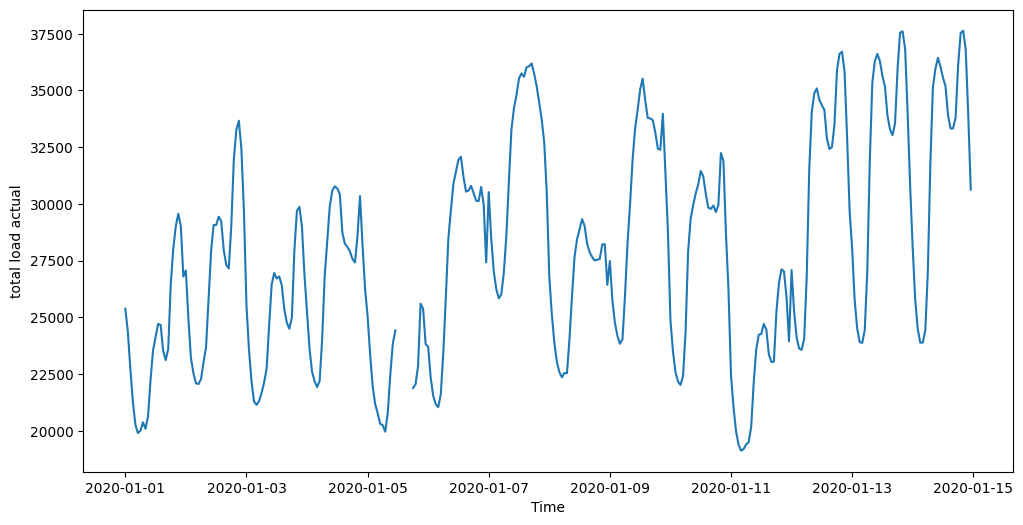

In [ ]:
plt.figure(figsize=(12,6))
# plot total load actual for two weeks duration
plt.plot(df_energy['total load actual'][:24*7*2])
plt.xlabel('Time')
plt.ylabel('total load actual')

<li> So, it seems there are not too many Nan values in dataframe.In general, if the number of missing values
is relatively small and the time series has a regular frequency, interpolation methods such as linear or
spline interpolation can be used to estimate the missing values. On the other hand, if the number of
missing values is large or if the missing values are irregularly spaced, it may be better to remove
them, as interpolating over large gaps can introduce noise and bias in the data. So we will linearly
interploate the nan values. </li>

In [ ]:
df_energy[df_energy.isna().any(axis = 1)]

generation biomass  \
time                                            
2020-01-05 03:00:00+01:00                 NaN   
2020-01-05 12:00:00+01:00                 NaN   
2020-01-05 13:00:00+01:00                 NaN   
2020-01-05 14:00:00+01:00                 NaN   
2020-01-05 15:00:00+01:00                 NaN   
2020-01-05 16:00:00+01:00                 NaN   
2020-01-05 17:00:00+01:00                 NaN   
2020-01-19 19:00:00+01:00                 NaN   
2020-01-19 20:00:00+01:00                 NaN   
2020-01-27 19:00:00+01:00                 NaN   
2020-01-28 13:00:00+01:00                 NaN   
2020-02-01 07:00:00+01:00               449.0   
2020-02-01 08:00:00+01:00               453.0   
2020-02-01 09:00:00+01:00               452.0   
2020-02-01 12:00:00+01:00               405.0   
2020-02-01 13:00:00+01:00               402.0   
2020-02-01 14:00:00+01:00               400.0   
2020-02-01 15:00:00+01:00               393.0   
2020-02-01 16:00:00+01:00               413.0   
2020-02-01 17:00:00+01:00               465.0   
2020-02-01 18:00:00+01:00               482.0   
2020-02-01 19:00:00+01:00               474.0   
2020-04-05 03:00:00+02:00               371.0   
2020-04-16 09:00:00+02:00                 NaN   
2020-04-20 08:00:00+02:00               424.0   
2020-04-23 21:00:00+02:00                 NaN   
2020-05-02 10:00:00+02:00               497.0   
2020-05-29 03:00:00+02:00               569.0   
2020-06-15 09:00:00+02:00                 NaN   
2020-10-02 08:00:00+02:00               483.0   
2020-10-02 11:00:00+02:00                 NaN   
2020-12-02 09:00:00+01:00                 NaN   
2021-04-13 05:00:00+02:00               220.0   
2021-04-25 05:00:00+02:00               190.0   
2021-04-25 07:00:00+02:00               206.0   
2021-05-10 23:00:00+02:00               348.0   
2021-06-12 01:00:00+02:00               356.0   
2021-07-09 22:00:00+02:00                 NaN   
2021-07-12 00:00:00+02:00               346.0   
2021-09-28 09:00:00+02:00               347.0   
2021-10-27 23:00:00+02:00               351.0   
2021-11-23 04:00:00+01:00                 NaN   
2022-11-14 12:00:00+01:00                 0.0   
2022-11-14 19:00:00+01:00                 0.0   
2023-06-11 18:00:00+02:00               331.0   
2023-07-11 09:00:00+02:00                 NaN   

                           generation fossil brown coal/lignite  \
time                                                              
2020-01-05 03:00:00+01:00                                   NaN   
2020-01-05 12:00:00+01:00                                   NaN   
2020-01-05 13:00:00+01:00                                   NaN   
2020-01-05 14:00:00+01:00                                   NaN   
2020-01-05 15:00:00+01:00                                   NaN   
2020-01-05 16:00:00+01:00                                   NaN   
2020-01-05 17:00:00+01:00                                   NaN   
2020-01-19 19:00:00+01:00                                   NaN   
2020-01-19 20:00:00+01:00                                   NaN   
2020-01-27 19:00:00+01:00                                   NaN   
2020-01-28 13:00:00+01:00                                   NaN   
2020-02-01 07:00:00+01:00                                 312.0   
2020-02-01 08:00:00+01:00                                 312.0   
2020-02-01 09:00:00+01:00                                 302.0   
2020-02-01 12:00:00+01:00                                 317.0   
2020-02-01 13:00:00+01:00                                 317.0   
2020-02-01 14:00:00+01:00                                 317.0   
2020-02-01 15:00:00+01:00                                 321.0   
2020-02-01 16:00:00+01:00                                 325.0   
2020-02-01 17:00:00+01:00                                 321.0   
2020-02-01 18:00:00+01:00                                 326.0   
2020-02-01 19:00:00+01:00                                 326.0   
2020-04-05 03:00:00+02:00                                   0.0   

In [ ]:
df_energy.interpolate(method='linear', limit_direction='forward', inplace = True)

<li> So, there is no any NaN value in the data! </li>

In [ ]:
df_energy.isnull().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

<strong> Feature Correlation </strong>

<li> Based on the feaure correlation,  There is a strong correlation between <strong>"generation fossil hard coal"</strong> and <strong>"generation fossil brown coal/lignite"</strong>. So with a common sense we can combine these two feature as a
<strong>"generation fossil total"</strong> and remove them. </li>

<strong> Note : </strong> There is a very high correlation between <strong>Total load forecasting</strong> and <strong>total load actual.</strong> For now,
I will keep this for visulization part of this project but before feeding the data into model I will drop this column.

In [ ]:
def feat_corr(input_df):
    corr = input_df.corr()
    plt.figure(figsize=(15,12))
    #plot heat map
    g=sns.heatmap(corr,annot=True,cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title('Feature Correlation')

    return plt.show()

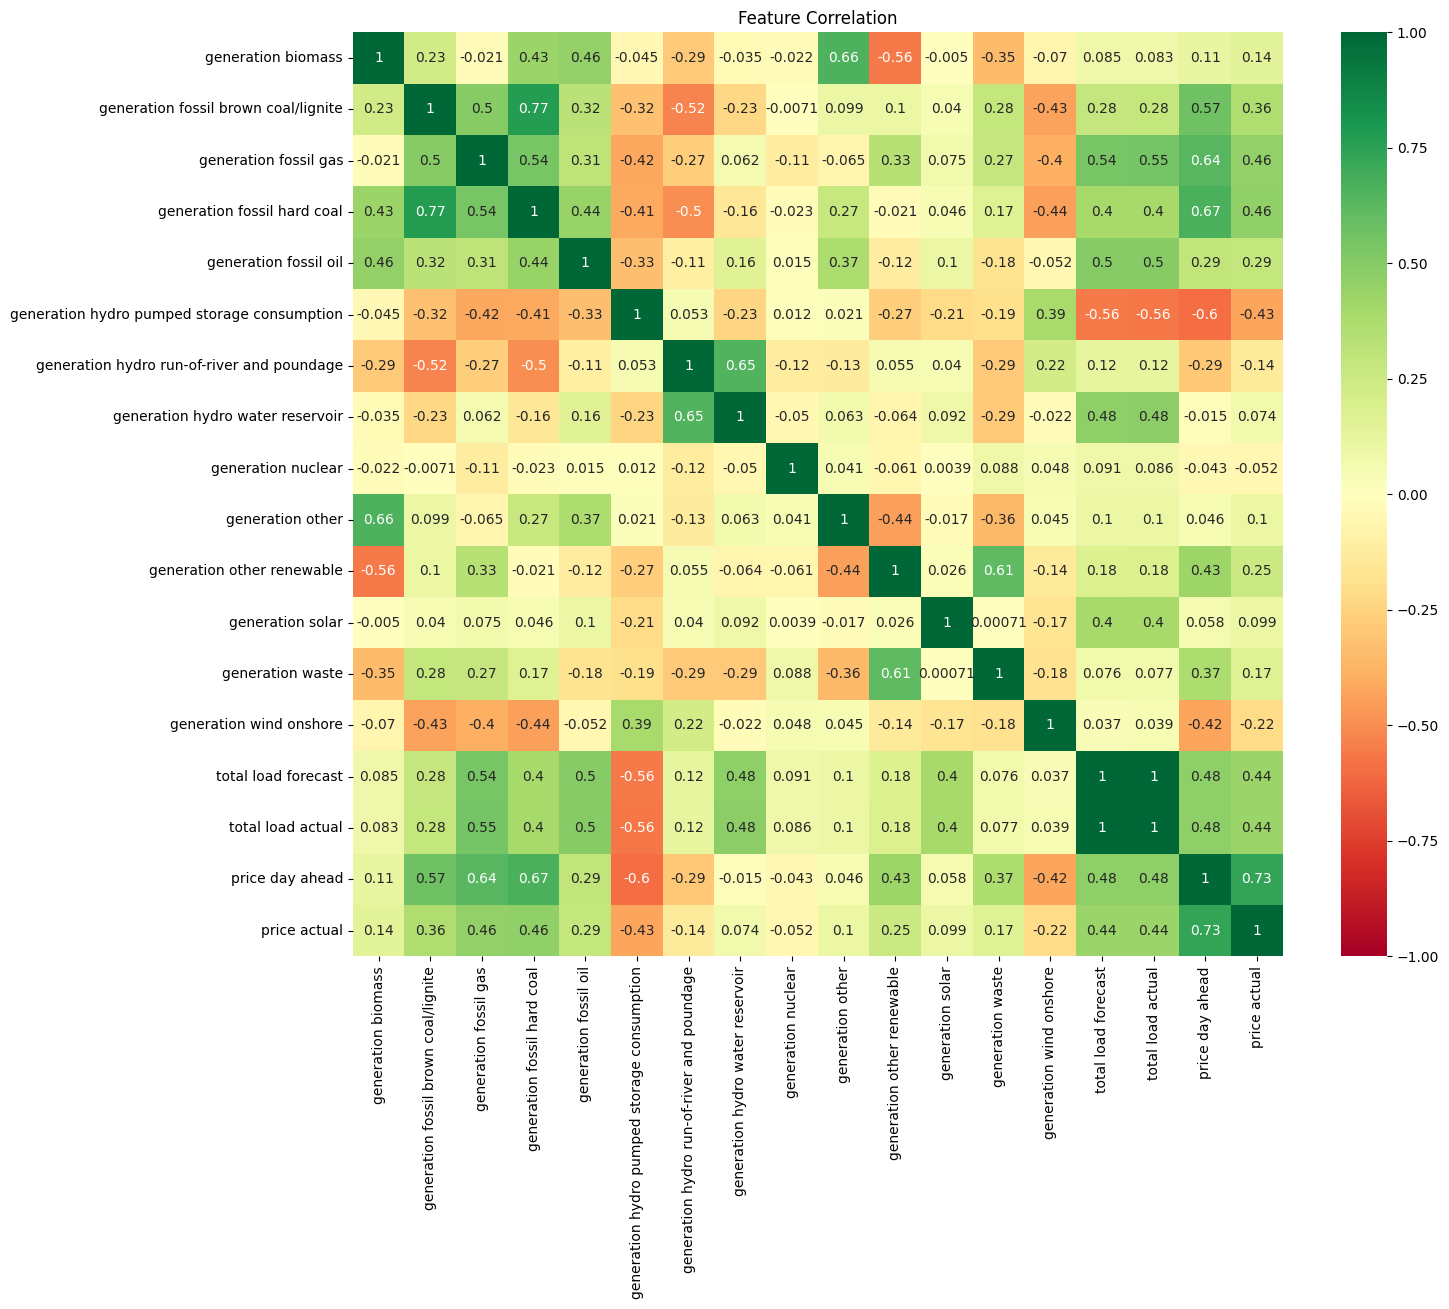

In [ ]:
feat_corr(df_energy)

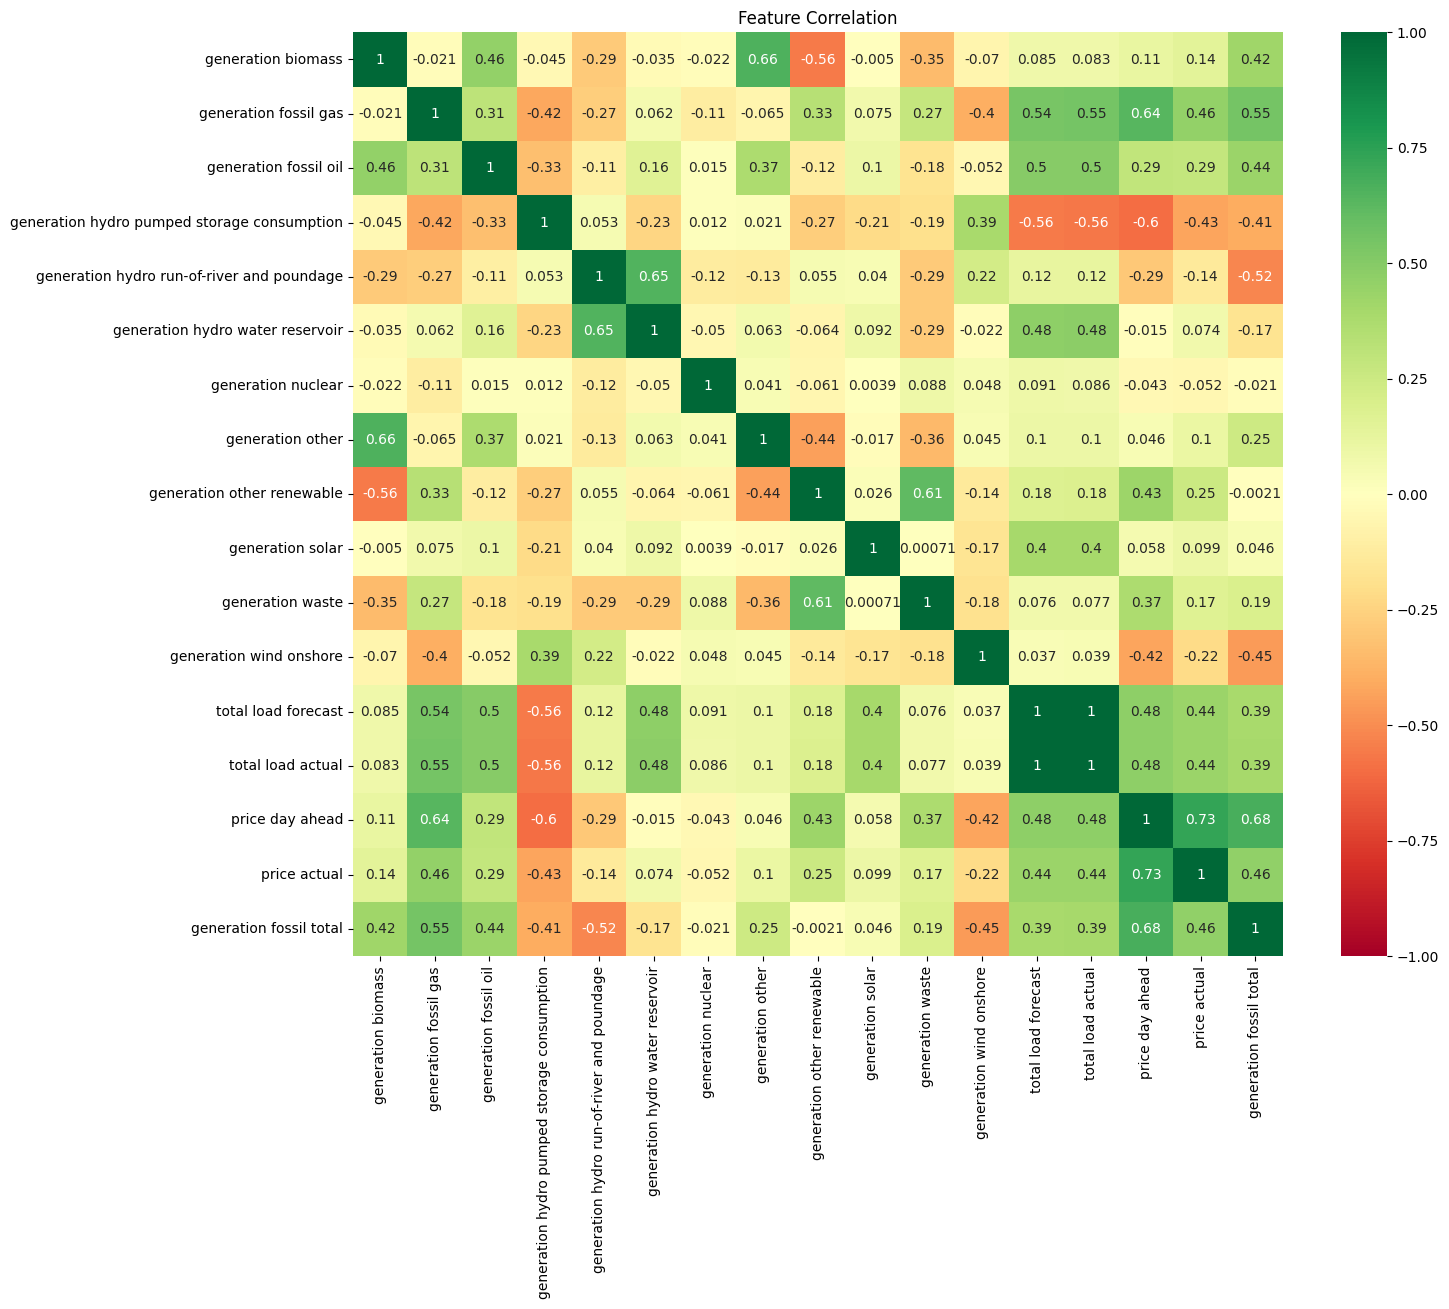

In [ ]:
df_energy["generation fossil total"] = df_energy['generation fossil hard coal'] + df_energy['generation fossil brown coal/lignite']
df_energy.drop(['generation fossil hard coal', 'generation fossil brown coal/lignite'], axis = 1, inplace = True)
feat_corr(df_energy)

<h3> Weather dataset </h3>

In [ ]:
# Loading weather data
df_weather = pd.read_csv('/content/drive/MyDrive/Keerthivasan_S_Electricity_Forecast_and_Demand_Prediction/data/weather_features.csv')

In [ ]:
df_weather.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2020-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2020-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2020-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2020-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2020-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

<li> Based on a quick look at the dataframe we will notice that <strong>'weather_icon'</strong> seems useless feature.
Beside that colud cover that is reflected in <strong>'weather_main' and 'weather_description'</strong> can afftect the prediction, but since
this is hourly requirements and since their effect is reflected in measured temprerature, we can drop these two columns as well and instead
we can keep <strong>'clouds_all'</strong>. But before deciding on which feature to drop, lets see the feature correlations.</li>

In [ ]:
df_temp = df_weather.copy(deep = True)
labels = ['weather_id', 'weather_main','weather_description','weather_icon']
for col in labels:
    df_temp[col] = LabelEncoder().fit_transform(df_weather[col])

<p>
</p>
<li> Apparantly there is strong correlation between the features that we talked about. Having strong correlation between
features might cuase multicolinearity. So, we can drop <strong>'weather_icon', 'weather_main', 'weather_description', and 'weather_id'</strong>
and just keep <strong>'clouds_all'</strong>. There is also a very strong correlation between 'temp', 'temp_min' and 'temp_max'. So we drop temp_max
and temp_min and just keep <strong> 'temp'</strong>.</li>

In [ ]:
def feat_corr_1(input_df):
    corr = input_df.corr()
    plt.figure(figsize=(15,12))
    g=sns.heatmap(corr,annot=True,cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title('Feature Correlation')

    return plt.show()

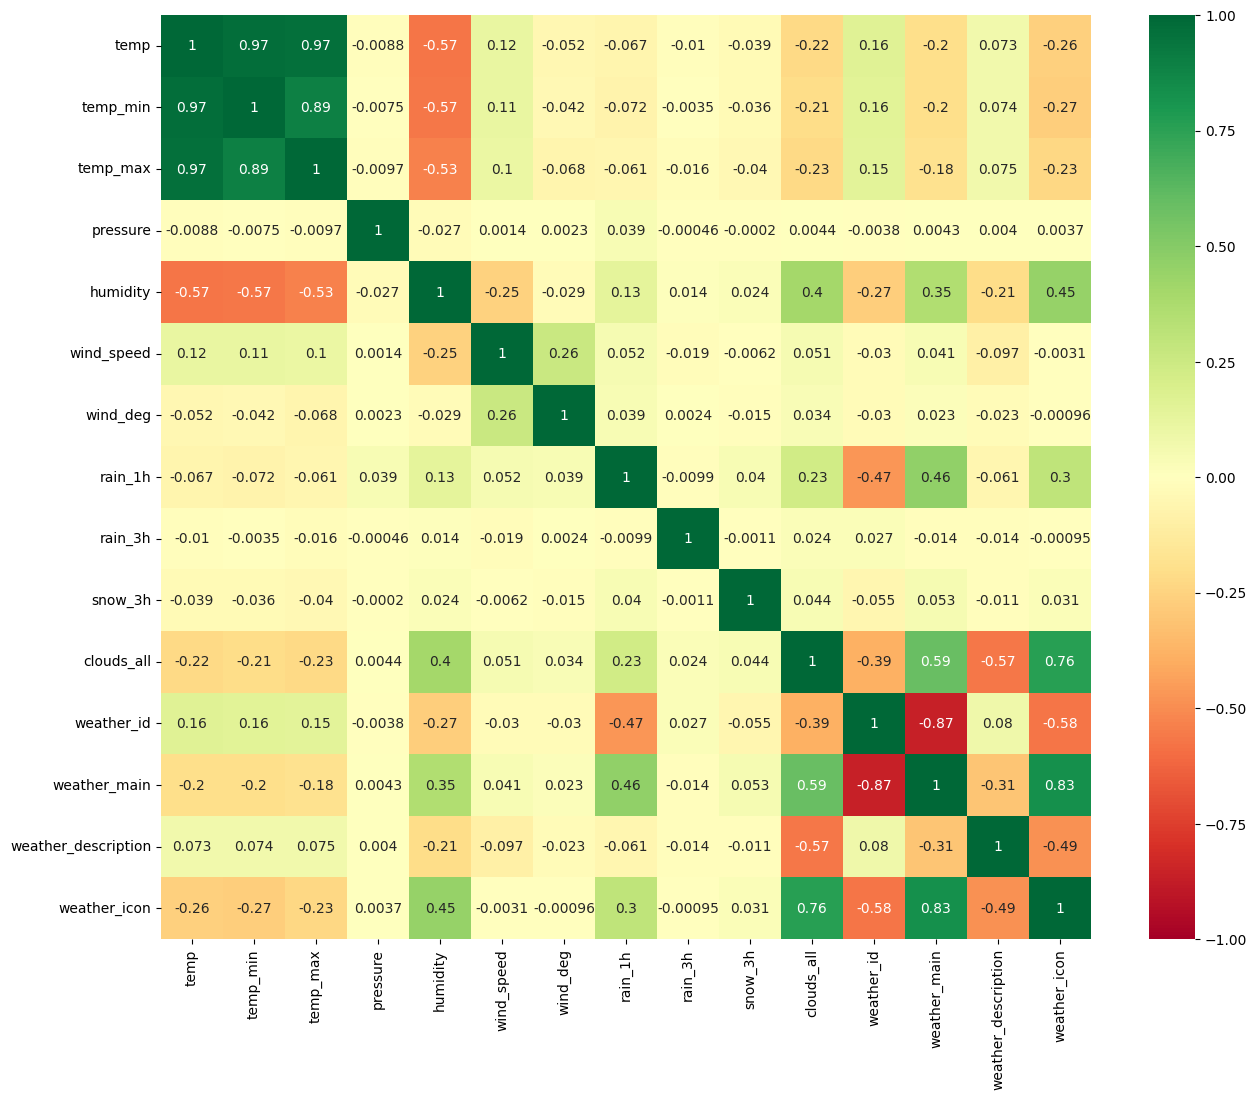

In [ ]:
feat_corr_1(df_temp)

In [ ]:
df_weather['weather_id'].unique()

array([800, 801, 802, 803, 804, 500, 501, 502, 701, 522, 521, 503, 202,
       200, 201, 211, 520, 300, 741, 301, 711, 302, 721, 310, 600, 616,
       615, 601, 210, 602, 611, 311, 612, 620, 531, 731, 761, 771])

In [ ]:
col_drop_name = ['weather_id', 'weather_main','weather_description','weather_icon', 'temp_min', 'temp_max']
# col_drop_name = ['weather_id', 'weather_main','weather_description','weather_icon']
df_weather.drop(col_drop_name, axis = 1 , inplace = True)

In [ ]:
check_Nans_Dups(df_weather)

Number of Nans in each column :
dt_iso        0
city_name     0
temp          0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
rain_1h       0
rain_3h       0
snow_3h       0
clouds_all    0
dtype: int64

Number of duplicates in the dataframe : 3076


In [ ]:
df_weather = df_weather.reset_index().drop_duplicates()

In [ ]:
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], errors='coerce')
invalid_dates = df_weather[df_weather['time'].isnull()]
df_weather = df_weather.dropna(subset=['time'])
df_weather.drop(["dt_iso"], axis=1, inplace=True)
df_weather = df_weather.set_index('time')
df_weather.drop(["index"], axis=1, inplace=True)

<ipython-input-42-116884bd5b84>:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], errors='coerce')
<ipython-input-42-116884bd5b84>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather.drop(["dt_iso"], axis=1, inplace=True)


In [ ]:
df_weather

city_name     temp  pressure  humidity  wind_speed  \
time                                                                           
2020-01-01 00:00:00+01:00  Valencia  270.475      1001        77           1   
2020-01-01 01:00:00+01:00  Valencia  270.475      1001        77           1   
2020-01-01 02:00:00+01:00  Valencia  269.686      1002        78           0   
2020-01-01 03:00:00+01:00  Valencia  269.686      1002        78           0   
2020-01-01 04:00:00+01:00  Valencia  269.686      1002        78           0   
...                             ...      ...       ...       ...         ...   
2023-12-31 19:00:00+01:00   Seville  287.760      1028        54           3   
2023-12-31 20:00:00+01:00   Seville  285.760      1029        62           3   
2023-12-31 21:00:00+01:00   Seville  285.150      1028        58           4   
2023-12-31 22:00:00+01:00   Seville  284.150      1029        57           4   
2023-12-31 23:00:00+01:00   Seville  283.970      1029        70           3   

                           wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  
time                                                                        
2020-01-01 00:00:00+01:00        62      0.0      0.0      0.0           0  
2020-01-01 01:00:00+01:00        62      0.0      0.0      0.0           0  
2020-01-01 02:00:00+01:00        23      0.0      0.0      0.0           0  
2020-01-01 03:00:00+01:00        23      0.0      0.0      0.0           0  
2020-01-01 04:00:00+01:00        23      0.0      0.0      0.0           0  
...                             ...      ...      ...      ...         ...  
2023-12-31 19:00:00+01:00        30      0.0      0.0      0.0           0  
2023-12-31 20:00:00+01:00        30      0.0      0.0      0.0           0  
2023-12-31 21:00:00+01:00        50      0.0      0.0      0.0           0  
2023-12-31 22:00:00+01:00        60      0.0      0.0      0.0           0  
2023-12-31 23:00:00+01:00        50      0.0      0.0      0.0           0  

[178276 rows x 10 columns]

In [ ]:
df_energy

generation biomass  generation fossil gas  \
time                                                                   
2020-01-01 00:00:00+01:00               447.0                 4844.0   
2020-01-01 01:00:00+01:00               449.0                 5196.0   
2020-01-01 02:00:00+01:00               448.0                 4857.0   
2020-01-01 03:00:00+01:00               438.0                 4314.0   
2020-01-01 04:00:00+01:00               428.0                 4130.0   
...                                       ...                    ...   
2023-12-31 19:00:00+01:00               297.0                 7634.0   
2023-12-31 20:00:00+01:00               296.0                 7241.0   
2023-12-31 21:00:00+01:00               292.0                 7025.0   
2023-12-31 22:00:00+01:00               293.0                 6562.0   
2023-12-31 23:00:00+01:00               290.0                 6926.0   

                           generation fossil oil  \
time                                               
2020-01-01 00:00:00+01:00                  162.0   
2020-01-01 01:00:00+01:00                  158.0   
2020-01-01 02:00:00+01:00                  157.0   
2020-01-01 03:00:00+01:00                  160.0   
2020-01-01 04:00:00+01:00                  156.0   
...                                          ...   
2023-12-31 19:00:00+01:00                  178.0   
2023-12-31 20:00:00+01:00                  174.0   
2023-12-31 21:00:00+01:00                  168.0   
2023-12-31 22:00:00+01:00                  163.0   
2023-12-31 23:00:00+01:00                  163.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2020-01-01 00:00:00+01:00                                        863.0   
2020-01-01 01:00:00+01:00                                        920.0   
2020-01-01 02:00:00+01:00                                       1164.0   
2020-01-01 03:00:00+01:00                                       1503.0   
2020-01-01 04:00:00+01:00                                       1826.0   
...                                                                ...   
2023-12-31 19:00:00+01:00                                          1.0   
2023-12-31 20:00:00+01:00                                          1.0   
2023-12-31 21:00:00+01:00                                         50.0   
2023-12-31 22:00:00+01:00                                        108.0   
2023-12-31 23:00:00+01:00                                        108.0   

                           generation hydro run-of-river and poundage  \
time                                                                    
2020-01-01 00:00:00+01:00                                      1051.0   
2020-01-01 01:00:00+01:00                                      1009.0   
2020-01-01 02:00:00+01:00                                       973.0   
2020-01-01 03:00:00+01:00                                       949.0   
2020-01-01 04:00:00+01:00                                       953.0   
...                                                               ...   
2023-12-31 19:00:00+01:00                                      1135.0   
2023-12-31 20:00:00+01:00                                      1172.0   
2023-12-31 21:00:00+01:00                                      1148.0   
2023-12-31 22:00:00+01:00                                      1128.0   
2023-12-31 23:00:00+01:00                                      1069.0   

                           generation hydro water reservoir  \
time                                                          
2020-01-01 00:00:00+01:00                            1899.0   
2020-01-01 01:00:00+01:00                            1658.0   
2020-01-01 02:00:00+01:00                            1371.0   
2020-01-01 03:00:00+01:00                             779.0   
2020-01-01 04:00:00+01:00                             720.0   
...                                                     ...

<li> Based on stats below, we can see that there are some outliers in pressure, wind_speed and maybe rain_1h and rain_3h.
So we can see outliers in the plots. we will remove pressure and wind_speed outlier and also drop rain_3h. Becuase
rain_3h is supposed to be the amount of percipitation in the last 3 hr which should be higher than rain_1h, but the plot
does not confirm this. So we drop rain_3h. </li>

In [ ]:
df_weather.describe().round(2)

temp    pressure   humidity  wind_speed   wind_deg    rain_1h  \
count  178276.00   178276.00  178276.00   178276.00  178276.00  178276.00   
mean      289.62     1069.30      68.43        2.47     166.51       0.08   
std         8.03     5971.64      21.90        2.09     116.58       0.40   
min       262.24        0.00       0.00        0.00       0.00       0.00   
25%       283.68     1013.00      53.00        1.00      55.00       0.00   
50%       289.15     1018.00      72.00        2.00     177.00       0.00   
75%       295.15     1022.00      87.00        4.00     270.00       0.00   
max       315.60  1008371.00     100.00      133.00     360.00      12.00   

         rain_3h    snow_3h  clouds_all  
count  178276.00  178276.00   178276.00  
mean        0.00       0.00       25.08  
std         0.01       0.22       30.78  
min         0.00       0.00        0.00  
25%         0.00       0.00        0.00  
50%         0.00       0.00       20.00  
75%         0.00       0.00       40.00  
max         2.32      21.50      100.00

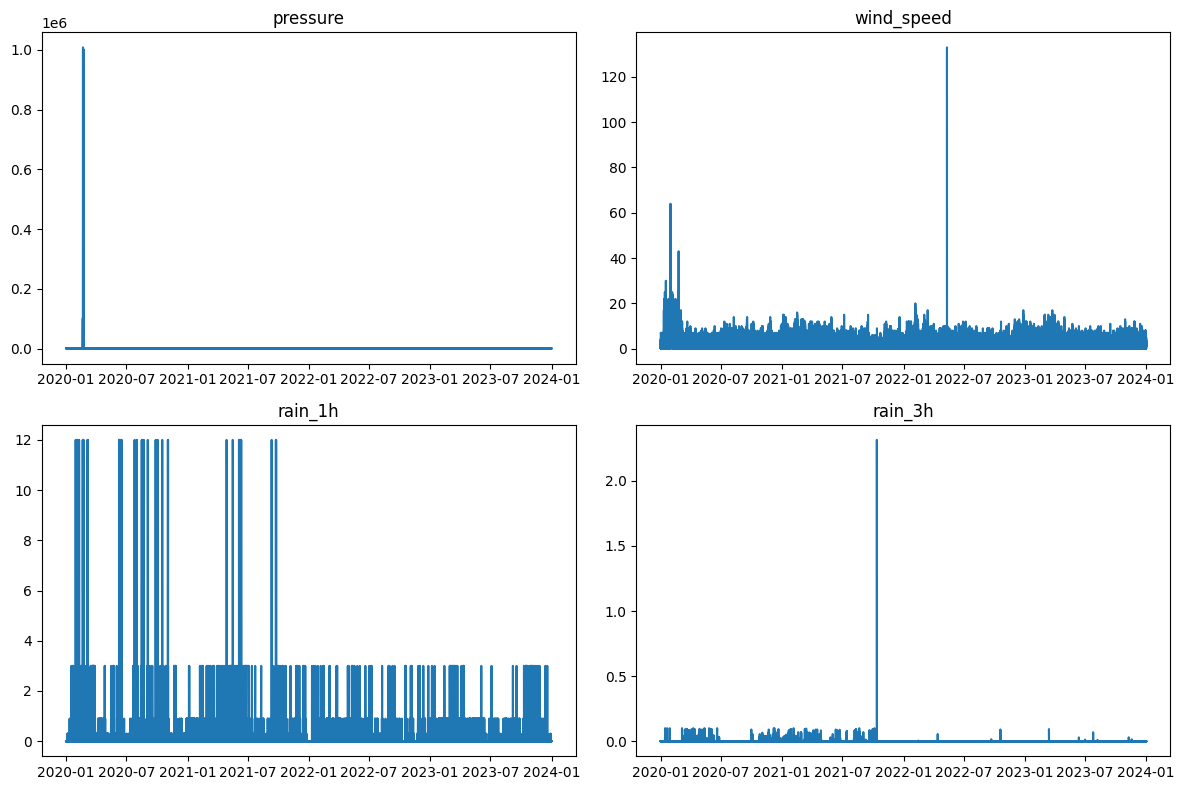

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# select the columns to plot
columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

# loop through the subplots and plot each column
for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.plot(df_weather.index, df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()  # display the plot

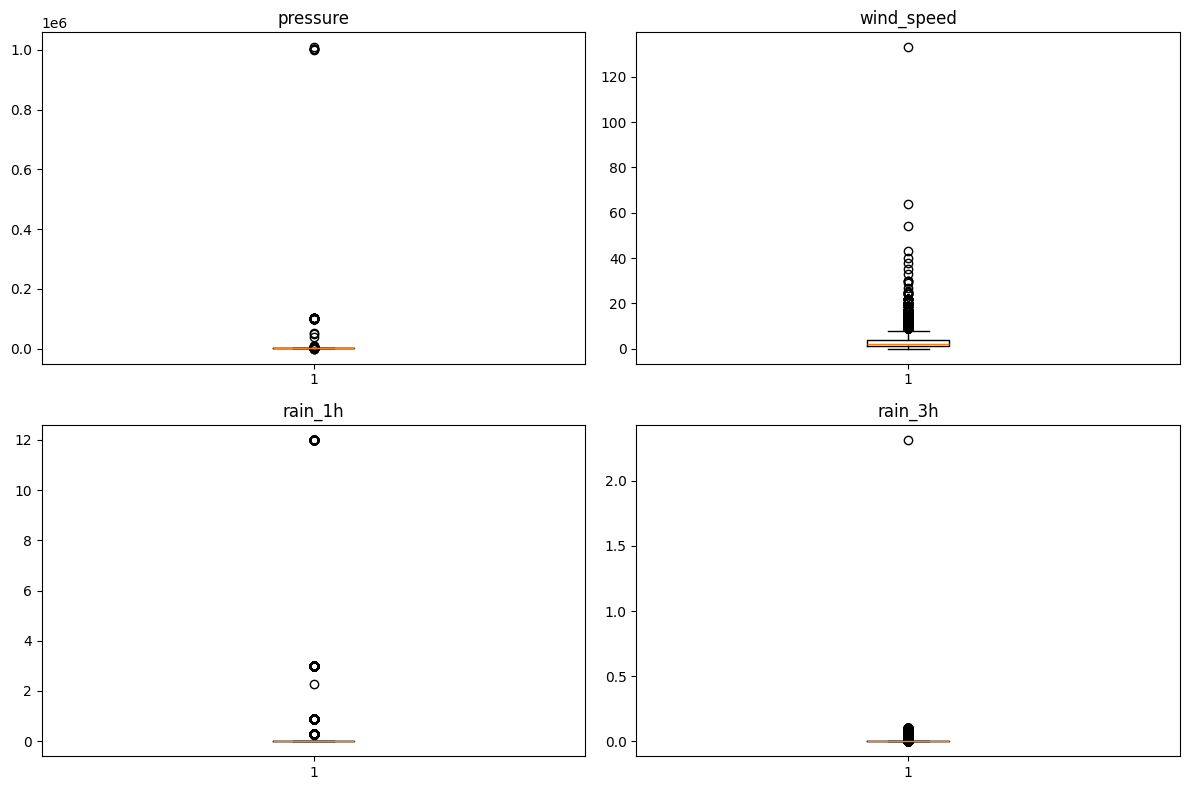

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# select the columns to plot
columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

# loop through the subplots and plot each column
for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.boxplot(x = df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()  # display the plot

<strong> Note: </strong>
<p>
</p>
<li> Maximum pressure on earth is recorded as 1080hPa :
<a href="https://wmo.asu.edu/content/world-highest-sea-level-air-pressure-below-700m">https://wmo.asu.edu/content/world-highest-sea-level-air-pressure-below-700m</a>
<li> Minimum pressure on earth is recorded as 870hPa :
<a href="https://wmo.asu.edu/content/world-lowest-sea-level-air-pressure-excluding-tornadoes">https://wmo.asu.edu/content/world-lowest-sea-level-air-pressure-excluding-tornadoes</a>
    
<li> Maximum wind speed on earth is recorded as 113 m/s : <a href="https://www.wunderground.com/cat6/the-highest-anemometer-measured-wind-speeds-on-earth">https://www.wunderground.com/cat6/the-highest-anemometer-measured-wind-speeds-on-earth</a>
<p>
</p>
<li> So we set the max threshold as these numbers and replace the outliers with Nan values and then use interpolation to fill the gap. </li>        

In [ ]:
df_weather.loc[df_weather['pressure']  > 1080,  'pressure'] = np.nan
df_weather.loc[df_weather['pressure']   < 870,  'pressure'] = np.nan
df_weather.loc[df_weather['wind_speed'] > 113, 'wind_speed'] = np.nan

df_weather.interpolate(method ='linear', limit_direction ='forward', inplace = True)

<ipython-input-48-e09d3d1c477d>:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_weather.interpolate(method ='linear', limit_direction ='forward', inplace = True)


<li> Check if the outliers are removed! </li>

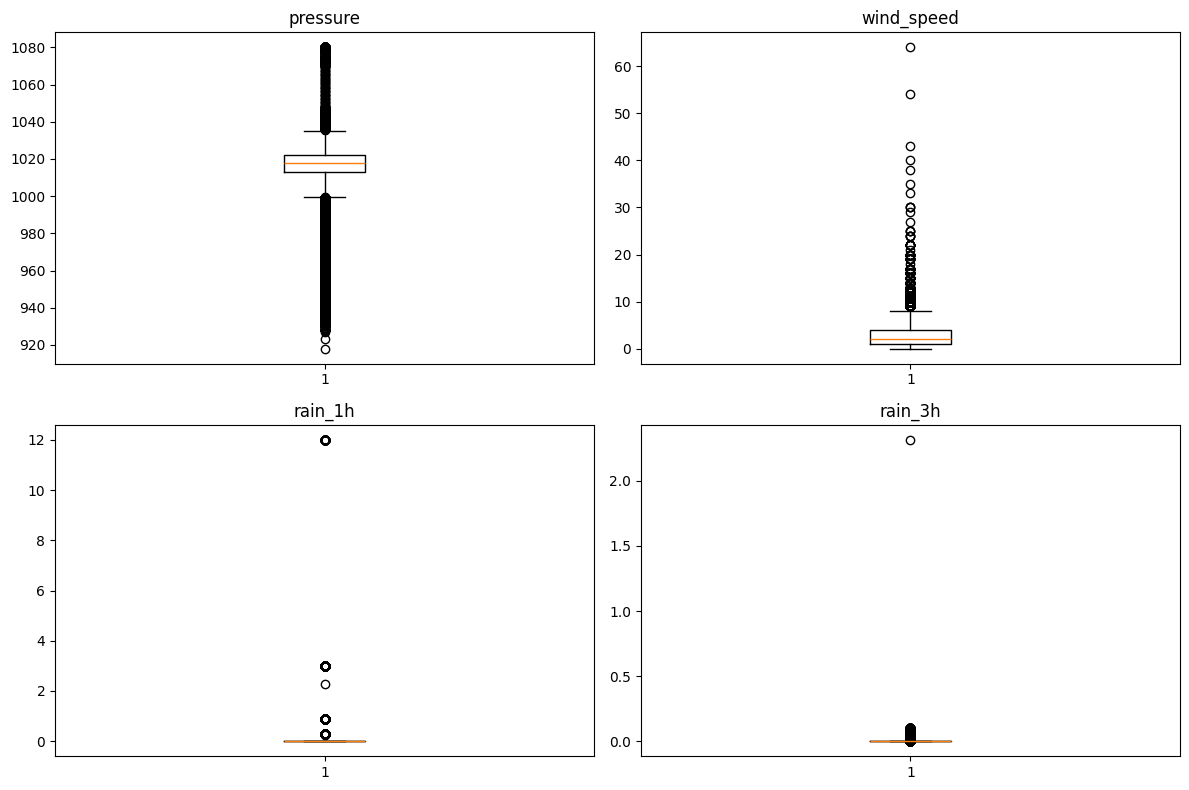

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# select the columns to plot
columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

# loop through the subplots and plot each column
for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.boxplot(x = df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()  # display the plot

In [ ]:
# be sure to drop rain_h3
df_weather.drop(['rain_3h'], axis = 1 , inplace = True)

<li> So number of samples in each group of city is not consistent! probably it has duplicates!</li>

In [ ]:
print(f'Number of samples in df_energy is {df_energy.shape[0]}')

city_list = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in city_list:
    print(f'Number of samples in df_weather in {city} is {grouped_weather.get_group(city).shape[0]}')

Number of samples in df_energy is 35040
Number of samples in df_weather in Valencia is 35121
Number of samples in df_weather in Madrid is 36243
Number of samples in df_weather in Bilbao is 35927
Number of samples in df_weather in  Barcelona is 35452
Number of samples in df_weather in Seville is 35533


In [ ]:
df_weather_cleaned = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='first').set_index('time')

In [ ]:
df_weather_cleaned

city_name     temp  pressure  humidity  wind_speed  \
time                                                                           
2020-01-01 00:00:00+01:00  Valencia  270.475    1001.0        77         1.0   
2020-01-01 01:00:00+01:00  Valencia  270.475    1001.0        77         1.0   
2020-01-01 02:00:00+01:00  Valencia  269.686    1002.0        78         0.0   
2020-01-01 03:00:00+01:00  Valencia  269.686    1002.0        78         0.0   
2020-01-01 04:00:00+01:00  Valencia  269.686    1002.0        78         0.0   
...                             ...      ...       ...       ...         ...   
2023-12-31 19:00:00+01:00   Seville  287.760    1028.0        54         3.0   
2023-12-31 20:00:00+01:00   Seville  285.760    1029.0        62         3.0   
2023-12-31 21:00:00+01:00   Seville  285.150    1028.0        58         4.0   
2023-12-31 22:00:00+01:00   Seville  284.150    1029.0        57         4.0   
2023-12-31 23:00:00+01:00   Seville  283.970    1029.0        70         3.0   

                           wind_deg  rain_1h  snow_3h  clouds_all  
time                                                               
2020-01-01 00:00:00+01:00        62      0.0      0.0           0  
2020-01-01 01:00:00+01:00        62      0.0      0.0           0  
2020-01-01 02:00:00+01:00        23      0.0      0.0           0  
2020-01-01 03:00:00+01:00        23      0.0      0.0           0  
2020-01-01 04:00:00+01:00        23      0.0      0.0           0  
...                             ...      ...      ...         ...  
2023-12-31 19:00:00+01:00        30      0.0      0.0           0  
2023-12-31 20:00:00+01:00        30      0.0      0.0           0  
2023-12-31 21:00:00+01:00        50      0.0      0.0           0  
2023-12-31 22:00:00+01:00        60      0.0      0.0           0  
2023-12-31 23:00:00+01:00        50      0.0      0.0           0  

[175200 rows x 9 columns]

<li> Now the number of samples in each group is the same! So we can concat weather dataframe with energy dataframe.</li>

In [ ]:
print(f'Number of samples in df_energy is {df_energy.shape[0]}')

city_list = df_weather['city_name'].unique()
grouped_weather = df_weather_cleaned.groupby('city_name')

for city in city_list:
    print(f'Number of samples in df_weather in {city} is {grouped_weather.get_group(city).shape[0]}')

Number of samples in df_energy is 35040
Number of samples in df_weather in Valencia is 35040
Number of samples in df_weather in Madrid is 35040
Number of samples in df_weather in Bilbao is 35040
Number of samples in df_weather in  Barcelona is 35040
Number of samples in df_weather in Seville is 35040


In [ ]:
df_weather_all_cities = [grouped_weather.get_group(x) for x in grouped_weather.groups]

In [ ]:
df_weather_all_cities[0]

city_name     temp  pressure  humidity  \
time                                                                 
2020-01-01 00:00:00+01:00   Barcelona  281.625    1035.0       100   
2020-01-01 01:00:00+01:00   Barcelona  281.625    1035.0       100   
2020-01-01 02:00:00+01:00   Barcelona  281.286    1036.0       100   
2020-01-01 03:00:00+01:00   Barcelona  281.286    1036.0       100   
2020-01-01 04:00:00+01:00   Barcelona  281.286    1036.0       100   
...                               ...      ...       ...       ...   
2023-12-31 19:00:00+01:00   Barcelona  284.130    1027.0        71   
2023-12-31 20:00:00+01:00   Barcelona  282.640    1027.0        62   
2023-12-31 21:00:00+01:00   Barcelona  282.140    1028.0        53   
2023-12-31 22:00:00+01:00   Barcelona  281.130    1028.0        50   
2023-12-31 23:00:00+01:00   Barcelona  280.130    1028.0       100   

                           wind_speed  wind_deg  rain_1h  snow_3h  clouds_all  
time                                                                           
2020-01-01 00:00:00+01:00         7.0        58      0.0      0.0           0  
2020-01-01 01:00:00+01:00         7.0        58      0.0      0.0           0  
2020-01-01 02:00:00+01:00         7.0        48      0.0      0.0           0  
2020-01-01 03:00:00+01:00         7.0        48      0.0      0.0           0  
2020-01-01 04:00:00+01:00         7.0        48      0.0      0.0           0  
...                               ...       ...      ...      ...         ...  
2023-12-31 19:00:00+01:00         1.0       250      0.0      0.0           0  
2023-12-31 20:00:00+01:00         3.0       270      0.0      0.0           0  
2023-12-31 21:00:00+01:00         4.0       300      0.0      0.0           0  
2023-12-31 22:00:00+01:00         5.0       320      0.0      0.0           0  
2023-12-31 23:00:00+01:00         5.0       310      0.0      0.0           0  

[35040 rows x 9 columns]

In [ ]:
df_weather_energy = df_energy

for df_city in df_weather_all_cities:
    city_name = df_city.iloc[0]['city_name'].replace(' ', '')
    df_temp_city = df_city.add_suffix(f'_{city_name}')
    df_weather_energy = pd.concat([df_weather_energy, df_temp_city], axis=1)
    df_weather_energy = df_weather_energy.drop(f'city_name_{city_name}' , axis=1)

In [ ]:
df_weather_energy.columns

Index(['generation biomass', 'generation fossil gas', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual',
       'generation fossil total', 'temp_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'snow_3h_Barcelona', 'clouds_all_Barcelona',
       'temp_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'snow_3h_Bilbao', 'clouds_all_Bilbao', 'temp_Madrid', 'pressure_Madrid',
       'humidity_Madrid', 'wind_speed_Madrid', 'wind_deg_Madrid',
       'rain_1h_Madrid', 'snow_3h_Madri

<li> So far, so good! There is no duplicates and Nans in df_weather_energy! </li>

In [ ]:
check_Nans_Dups(df_weather_energy)

Number of Nans in each column :
generation biomass                             0
generation fossil gas                          0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
generation fossil total                        0
temp_Barcelona                                 0
pressure_Barcelona                             0
humidity_Barcelona                   

<li>There are some powerful feature engineering techniques for time series that can boost the model perfroamnce:

<a href="https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/">https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/</a>
<p>
</p>
<li> For now, we are adding <strong>hour, weekday and month</strong> features to dataframe. These information can be helpful. For example in
shoulder seasons the heating and cooling load of all residential and commercial buildings will be low compared to summer/winter. or at the
weekend, since the office buildings are closed, the energy consumption will be lower.Regading the time, defintily energy consumption at 3 am
is way lower than the energy consumption at 10 am. So these features can be very helpful in building a good model.</li>
<p>
</p>

In [ ]:
df_weather_energy['hour'] = df_weather_energy.index.map(lambda x : x.hour)
df_weather_energy['weekday'] = df_weather_energy.index.map(lambda x : x.weekday())
df_weather_energy['month'] = df_weather_energy.index.map(lambda x : x.month)
df_weather_energy['year'] = df_weather_energy.index.map(lambda x: x.year)

In [ ]:
df_weather_energy.columns

Index(['generation biomass', 'generation fossil gas', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual',
       'generation fossil total', 'temp_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'snow_3h_Barcelona', 'clouds_all_Barcelona',
       'temp_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'snow_3h_Bilbao', 'clouds_all_Bilbao', 'temp_Madrid', 'pressure_Madrid',
       'humidity_Madrid', 'wind_speed_Madrid', 'wind_deg_Madrid',
       'rain_1h_Madrid', 'snow_3h_Madri

<h3> Visualization </h3>

In [ ]:
fig = make_subplots()

fig.add_trace(
    go.Line(x=df_weather_energy.index, y=df_weather_energy["price actual"],
                                name="price actual"))
fig.add_trace(
    go.Line(x=df_weather_energy.index,y=df_weather_energy.rolling(window=24).mean()["price actual"],
                                        name="rolling window = daily ave"))
fig.add_trace(
    go.Line(x=df_weather_energy.index,y=df_weather_energy.rolling(window=24*7).mean()["price actual"],
                                        name="rolling window = weekly ave"))
# fig.update_xaxes(rangeslider_visible=True)
fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




<li> Based on the month bar plot, the actual price in Jan and Dec is high and on weekly daily basis,
we witness the lowest price at weekends. </li>

Text(0.5, 1.0, 'Daily actual price (0 is Monday)')

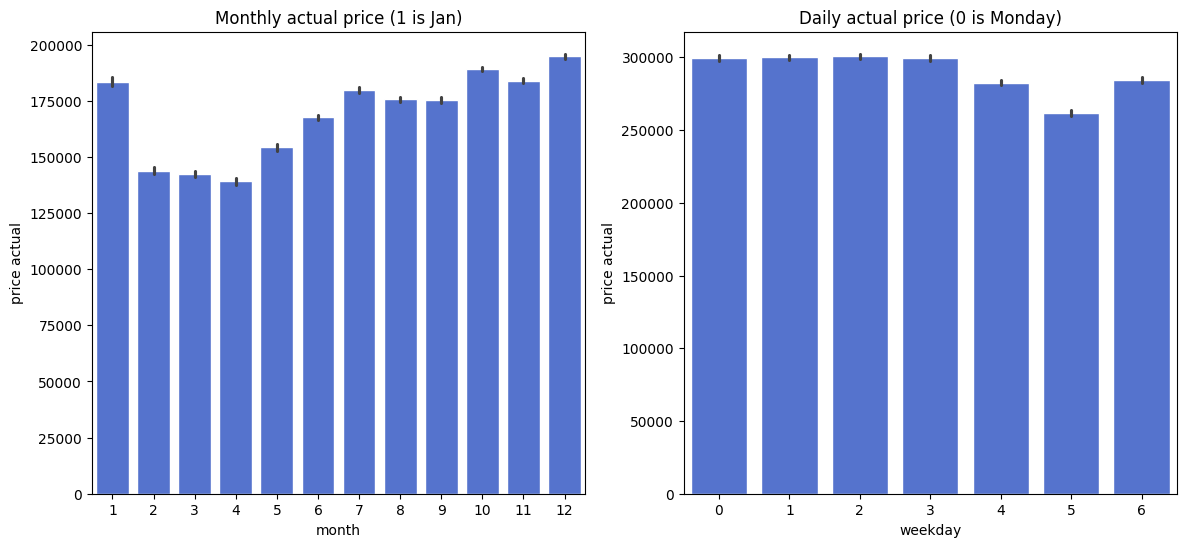

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.set(style="darkgrid")

sns.barplot(
    x="month",
    y="price actual",
    data=df_weather_energy,
    estimator=sum,
    color='royalblue',
    ax=axes[0]);
axes[0].set_title('Monthly actual price (1 is Jan)')

sns.barplot(
    x="weekday",
    y="price actual",
    data=df_weather_energy,
    estimator=sum,
    color='royalblue',
    ax=axes[1]);
axes[1].set_title('Daily actual price (0 is Monday)')


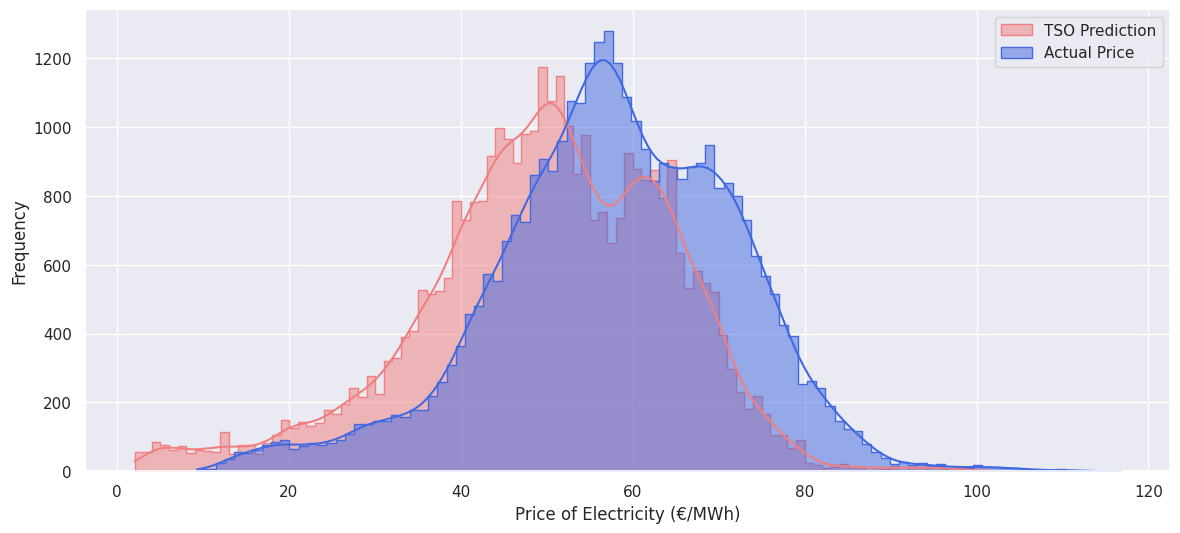

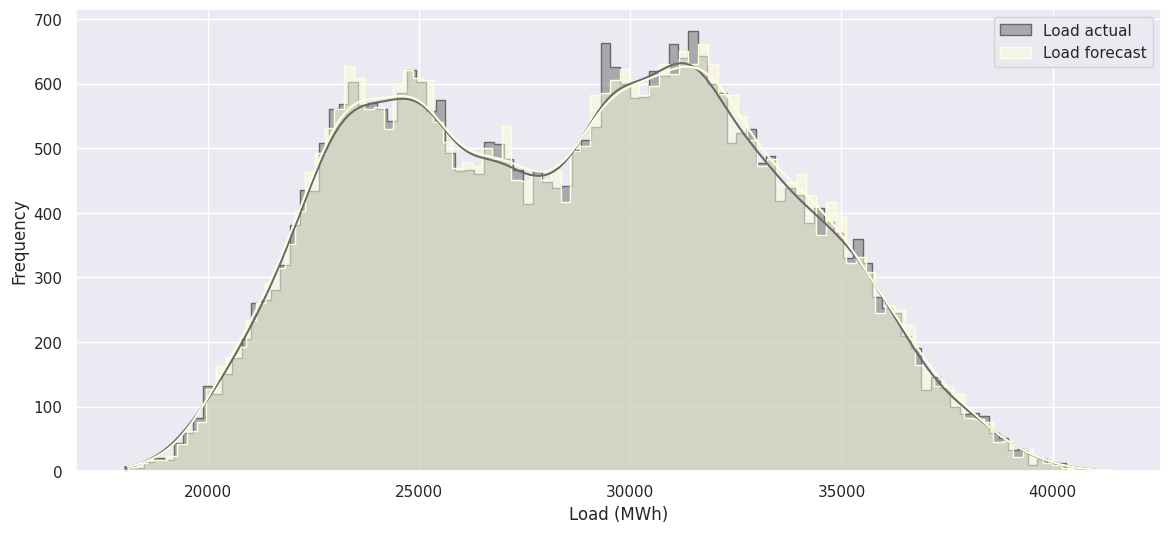

In [ ]:
plt.figure(figsize=(14,6))

gr = sns.histplot(df_weather_energy['price day ahead'], bins=100, label='TSO Prediction', element="step", color='lightcoral', kde = True)
gr = sns.histplot(df_weather_energy['price actual'], bins=100, label='Actual Price', element="step", color='royalblue', kde = True)


gr.set(xlabel="Price of Electricity (€/MWh)", ylabel="Frequency")
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
gr = sns.histplot(df_weather_energy['total load actual'], bins=100, label='Load actual', element="step", color='dimgrey', kde = True)
gr = sns.histplot(df_weather_energy['total load forecast'], bins=100, label='Load forecast', element="step", color='lightyellow', kde = True)

gr.set(xlabel="Load (MWh)", ylabel="Frequency")
plt.legend()
plt.show()

<li> I tried to estimate the mean absolute error for <strong> normalized </strong> acutal price and TSO predcition (price day ahead) on the test set.
I tried to normalized the data because I used normalized data for training part, so the comparision would be easy.
Later you will find I considered that last 10 % of the data as test set! so <strong> int(0.9*df_weather_energy.shape[0])
</strong> represents the begining index of the test size. So the MAE for TSO prediction for the test size is <strong> 0.07 </strong> </li>

In [ ]:
y_scaler_actual = MinMaxScaler()
y_scaler_dayahead = MinMaxScaler()

train_cutoff = int(0.8*df_weather_energy.shape[0])
val_cutoff = int(0.9*df_weather_energy.shape[0])

y_price_actual   = df_weather_energy[['price actual']]
y_price_dayahead = df_weather_energy[['price day ahead']]

y_scaler_actual.fit(y_price_actual[:train_cutoff])
actual_norm = y_scaler_actual.transform(y_price_actual)

y_scaler_dayahead.fit(df_weather_energy[['price day ahead']][:train_cutoff])
dayahead_norm = y_scaler_dayahead.transform(y_price_dayahead)

print(f' mean absolute error for normalized acutal price and TSO predcition is : {round(mean_absolute_error(actual_norm, dayahead_norm),3)}')

 mean absolute error for normalized acutal price and TSO predcition is : 0.071


<li> As I already explained above, we need to drop <strong> total load forecast</strong> from the data! </li>

In [ ]:
df_weather_energy.drop(['total load forecast'], axis = 1, inplace = True)

<li> So I decompose the price actual into trend, seasonality and residual(noise). for better visualization,
I ploted 100 first observed seasonality and call it as zoomed seasonality.</li>

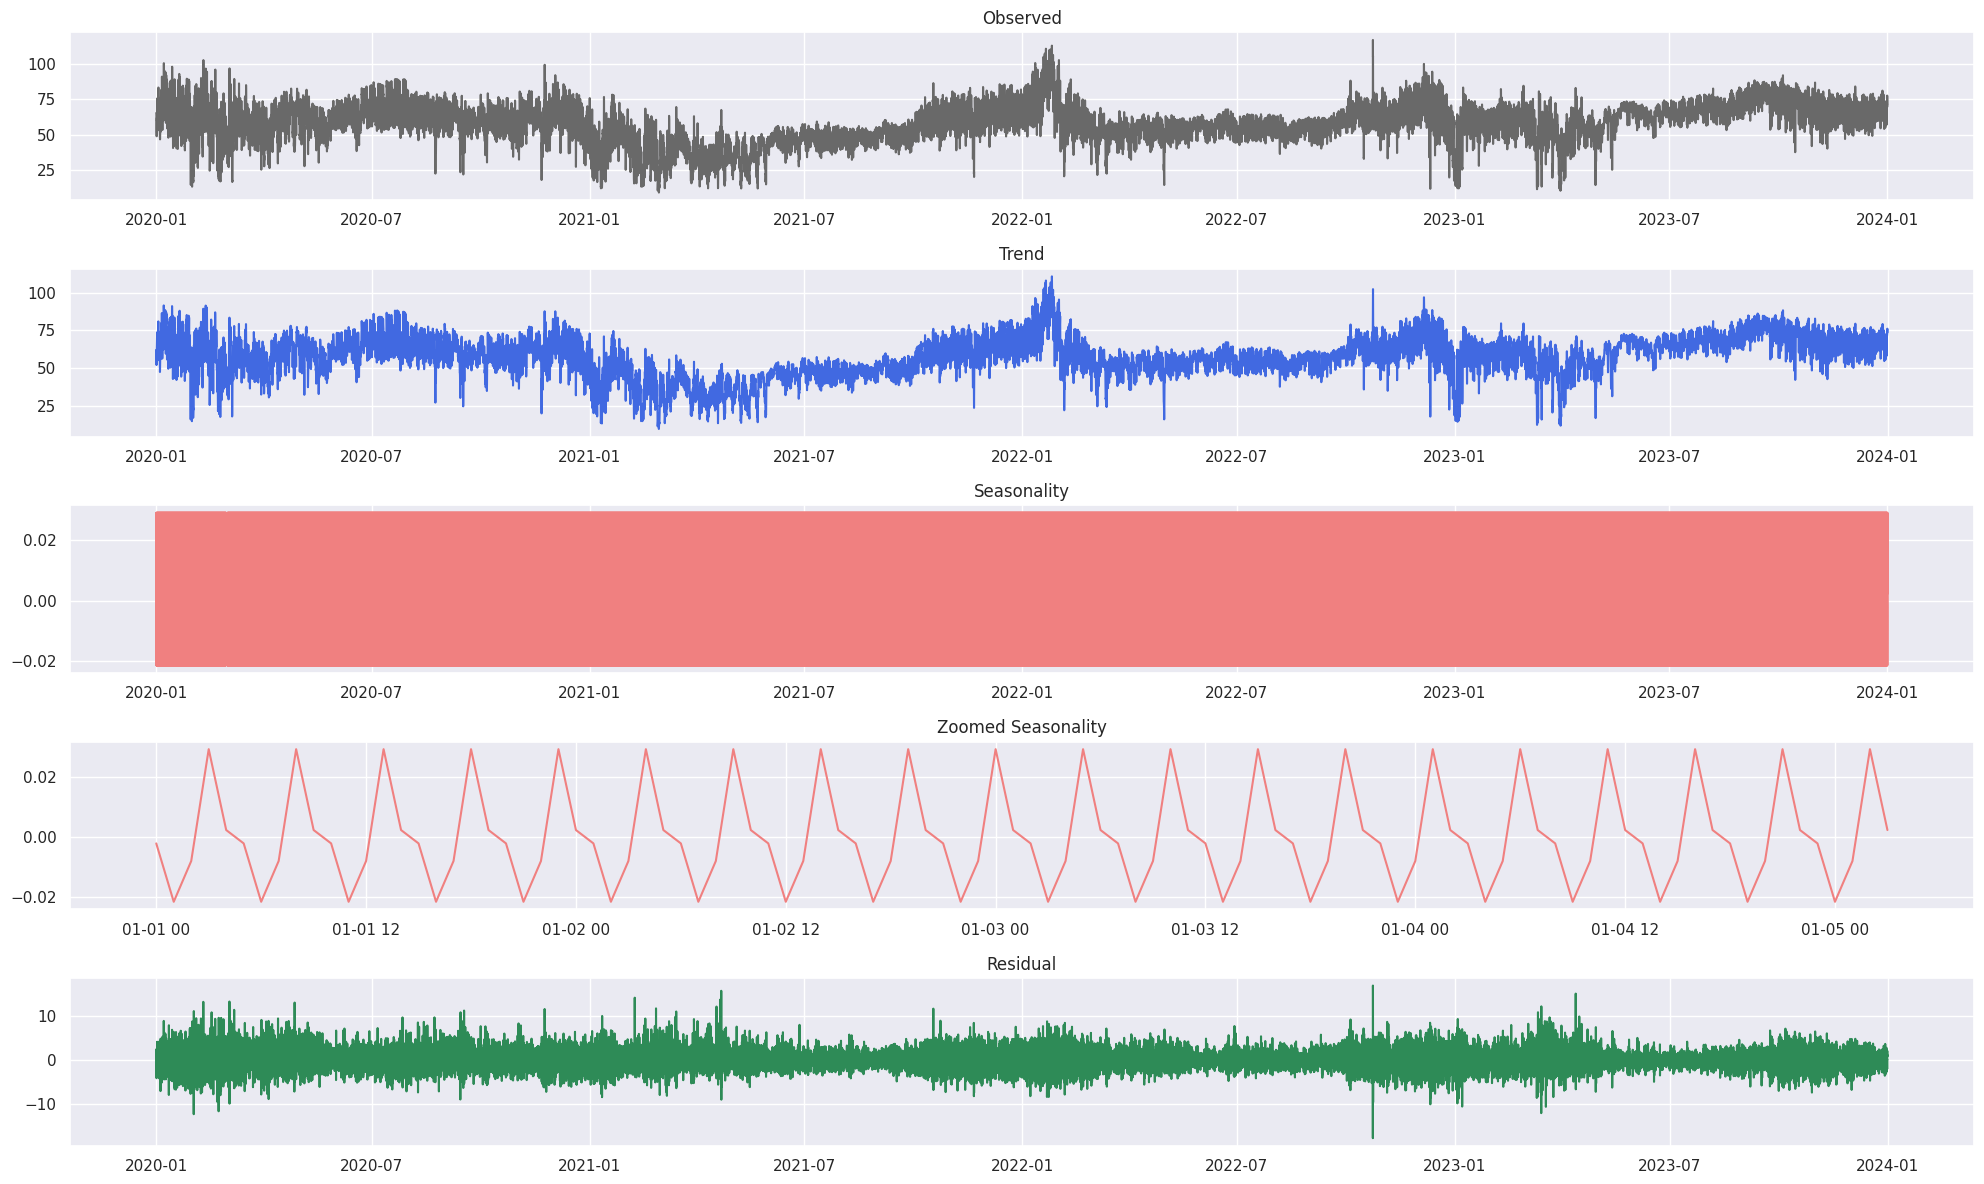

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(20, 12))
decom_data = df_weather_energy[['price actual']].copy()

decompose_result = seasonal_decompose(decom_data, period =5, model='additive')

observed    = decompose_result.observed
trend    = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

axes[0].plot(observed, color='dimgrey')
axes[0].set_title('Observed')
axes[1].plot(trend, color='royalblue')
axes[1].set_title('Trend')
axes[2].plot(seasonal, color='lightcoral')
axes[2].set_title('Seasonality')
axes[3].plot(seasonal[:100], color='lightcoral')
axes[3].set_title('Zoomed Seasonality')
axes[4].plot(residual, color='seagreen')
axes[4].set_title('Residual')

fig.tight_layout()
plt.show()


<li> <strong> The Dickey-Fuller test </strong>, also known as the Augmented Dickey-Fuller (ADF) test, is a statistical test used to
determine whether a time series is <strong> stationary </strong> or not. Stationarity is an important concept in time series analysis
because it affects the ability to model and predict future values. The test uses a null hypothesis that the time
series has a unit root, meaning that it is non-stationary. The alternative hypothesis is that the time series
is stationary. The test statistic is compared to critical values from tables or computed via a statistical
software package. If the test statistic is less than the critical value, the null hypothesis is rejected,
and it is concluded that the time series is stationary.</li>
<p>
</p>
<li> In the context of time series analysis, stationarity refers to a property of a time series where the
statistical properties of the series <strong> do not change over time </strong>. More specifically, a stationary time series is
one where <strong> the mean, variance, and autocorrelation </strong> structure of the series do not depend on the time at which
they are computed.</li>
<p>
</p>
<li>The concept of stationarity is important in time series analysis because it simplifies the modeling process and
enables the use of statistical tools that assume stationarity, such as  <strong>ARMA</strong> (autoregressive moving average) models.
In contrast, non-stationary time series can exhibit trends, seasonality, and other systematic patterns that can
make it difficult to model and forecast accurately.</li>


In [ ]:
result = adfuller(df_weather_energy[['price actual']])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -9.161409510857775
p-value: 2.5271768494086844e-15
Critical Values: {'1%': -3.4305369095948914, '5%': -2.8616226094213086, '10%': -2.5668139703987647}


<li> So based on the comments above we can see that the ADF statistics is even lower than the p value with 1%
significance level. So the time series is considered as stationary! </li>

<li> <strong>Autocorrelation</strong> is a measure of the linear dependence between a time series and its lagged values. It measures
how strongly the values of a time series at one time are correlated with the values at other times. Autocorrelation
can be positive (indicating that high values tend to be followed by high values and low values tend to be followed
by low values) or negative (indicating that high values tend to be followed by low values and vice versa). </li>
<p>
</p>
<li> <strong>Partial autocorrelation</strong>, on the other hand, measures the linear dependence between a time series and its lagged
values, <strong> after removing the effect of any intermediate lags </strong>. It provides a measure of the direct correlation between
two time points, taking into account any indirect correlation through intermediate time points. Partial autocorrelation
can help identify the <strong> order </strong> of an autoregressive (AR) model, which is a model that uses lagged values of the time series
as predictors. </li>

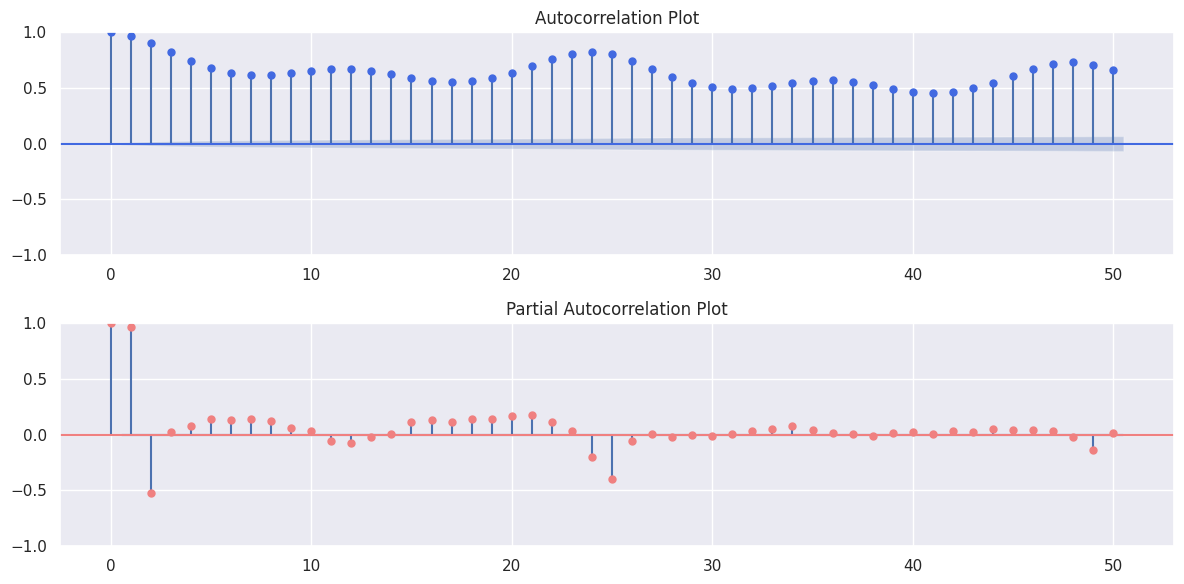

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df_weather_energy['price actual'], lags=50, ax=ax[0], color='royalblue')
ax[0].set_title('Autocorrelation Plot')
plot_pacf(df_weather_energy['price actual'], lags=50, ax=ax[1], color='lightcoral')
ax[1].set_title('Partial Autocorrelation Plot')
plt.tight_layout()
plt.show()

<li> Based on the partial autocorrolation, we have strong correlation of an observation with its past 25 values (after 25,
the correlation becomes very weak). So we use <strong> 25 </strong> lag feature for our time series! </li>

<h3> Dimensionality reduction and train-test split </h3>
<p>
</p>
<li> In this section I applied PCA for dimensionality reduction and add windowing to the dataset to make it prepared as input for tensorflow. I also split the train, validation and test sets and plot it with seperate colors in the figure.
For faster convergnce and better performance of ML/DL models I normalzed the dataset. </li>

In [ ]:
X = df_weather_energy.drop(['price actual'], axis = 1)
y= df_weather_energy[['price actual']]


In [ ]:
def apply_PCA(X_input, cum_variance, if_apply):

    if if_apply:

        pca = PCA(n_components = cum_variance)
        # make pipeline to first standardize then apply PCA on data
        scaler_pca = make_pipeline(MinMaxScaler(), pca)
        X_pca = scaler_pca.fit(X_input).transform(X_input)

        return X_pca

    else:

        return np.array(X_input)

In [ ]:
params_pca = {'cum_variance' : 0.8, 'if_apply' : True }
X_pca = apply_PCA(X, **params_pca)
X_pca.shape

(35040, 15)

In [ ]:
def windowing(X_input,y_input, history_size):

    data = []
    labels = []
    for i in range(history_size, len(y_input)):
        data.append(X_input[i - history_size : i, :])
        labels.append(y_input[i])

    return np.array(data), np.array(labels).reshape(-1,1)

<li> Normalizing target varialbe, since we already normalized features during the process of applying PCA! </li>

In [ ]:
train_cutoff = int(0.8*X_pca.shape[0])
val_cutoff   = int(0.9*X_pca.shape[0])

scaler_y = MinMaxScaler()
scaler_y.fit(y[:train_cutoff])
y_norm = scaler_y.transform(y)

<li> hist_size is the history size equivalent to look back! </li>

In [ ]:
hist_size= 24
data_norm = np.concatenate((X_pca,y_norm), axis = 1)

X_train, y_train = windowing(data_norm[:train_cutoff,:],data_norm[:train_cutoff,-1], hist_size)
X_val, y_val     = windowing(data_norm[train_cutoff :val_cutoff,:],data_norm[train_cutoff:val_cutoff,-1], hist_size)
X_test, y_test   = windowing(data_norm[val_cutoff :,:],data_norm[val_cutoff:,-1], hist_size)

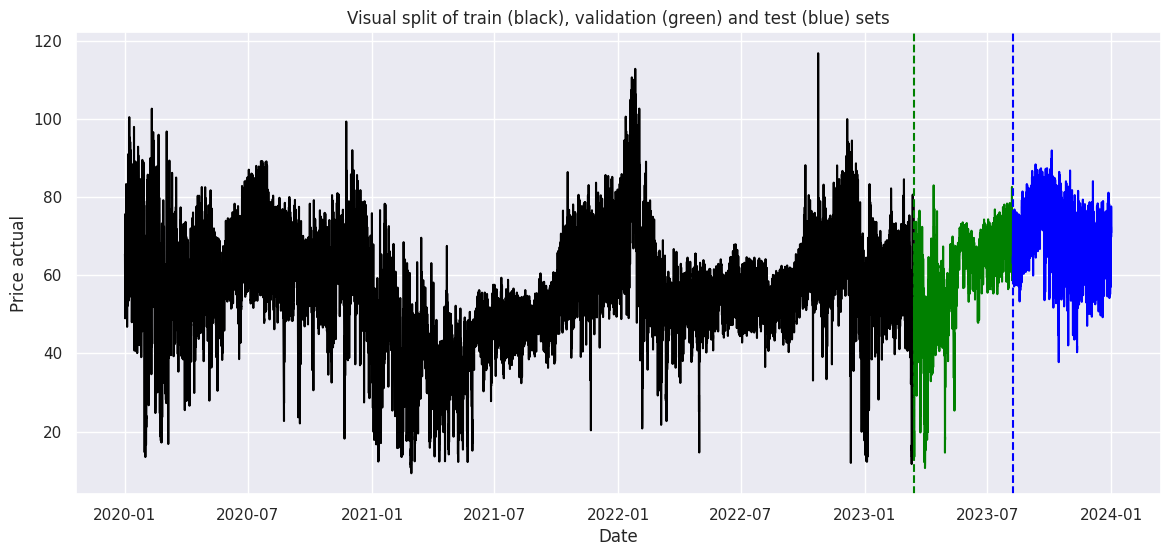

In [ ]:
fig, axes = plt.subplots(figsize = (14,6))
axes.plot(df_weather_energy['price actual'].iloc[:train_cutoff], color = 'black')
axes.plot(df_weather_energy['price actual'].iloc[train_cutoff + 1 : val_cutoff], color = 'green')
axes.plot(df_weather_energy['price actual'].iloc[val_cutoff + 1 :], color = 'blue')
axes.axvline(x=df_weather_energy.index[train_cutoff], color='green', linestyle='--')
axes.axvline(x=df_weather_energy.index[val_cutoff], color='blue', linestyle='--')
axes.set_title('Visual split of train (black), validation (green) and test (blue) sets')
axes.set_xlabel('Date')
axes.set_ylabel('Price actual')
plt.show()

<h2> Forecasting </h2>

<h3> 1. XGBoost </h3>

In [ ]:
def reshaping(X):

    reshaped_x = X.reshape(-1 , X.shape[1] * X.shape[2])
    return reshaped_x

X_train_xgb = reshaping(X_train)
X_val_xgb   = reshaping(X_val)
X_test_xgb  = reshaping(X_test)

In [ ]:
xgb_model = xgb.XGBRegressor()

xgb_model.fit(X_train_xgb, y_train,
               eval_set=[(X_train_xgb, y_train), (X_val_xgb, y_val)],
               eval_metric='mae',
               early_stopping_rounds=8,
               verbose=False)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
def plot_results(y_pred_actual, y_test_inv, model, model_name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))

    ax[0].plot(y_pred_actual[:1000])
    ax[0].plot(y_test_inv[:1000])
    ax[0].legend(['prediction', 'actual'], loc='upper left')
    ax[0].set_title(f'Prediction vs actual price for 1000 observation in test set ({model_name})')
    ax[0].set_xlabel('Observation')
    ax[0].set_ylabel('Price')

    if model != 'hybrid':

        if model_name == 'XGBoost':

            train_mae = model.evals_result()['validation_0']['mae']
            val_mae = model.evals_result()['validation_1']['mae']
            ax[1].plot(train_mae, label='Training MAE')
            ax[1].plot(val_mae, label='Validation MAE')

        else:

            ax[1].plot(history.history['loss'], label='Training Loss')
            ax[1].plot(history.history['val_loss'], label='Validation Loss')

        ax[1].legend()
        ax[1].set_title(f'Training and validation MAE ({model_name})')
        ax[1].set_xlabel('Iteration/Epochs')
        ax[1].set_ylabel('MAE')

    fig.tight_layout()
    plt.show()




---------------------------------------------------
XGBoost MAE for test set : 0.016
---------------------------------------------------



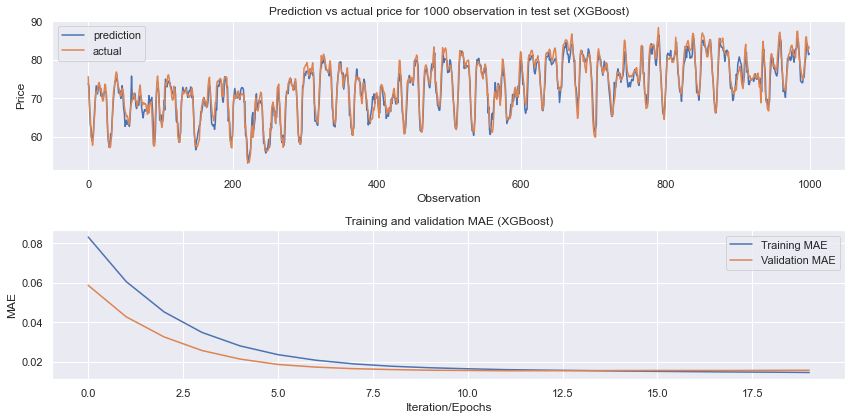

In [ ]:
y_pred = xgb_model.predict(X_test_xgb)
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1,1))
y_test_inv = scaler_y.inverse_transform(y_test)


print('')
print('')
print('---------------------------------------------------')
print(f'XGBoost MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
print('')
plot_results(y_pred_actual, y_test_inv, xgb_model,'XGBoost')

<h3> 2. GRU </h3>

In [ ]:
def base_model_gru():

    model = Sequential()
    model.add(GRU(units=32, return_sequences=True, activation="relu", input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    return model

gru_model = base_model_gru()


In [ ]:
epoch = 100
batch_size = 64
steps_per_epoch = len(X_train) // batch_size
cyclic_lr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-04,
                                                maximal_learning_rate=1e-02,
                                                scale_fn=lambda x: 1/(2**(x-1)),
                                                step_size=6 * steps_per_epoch)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
optimizer = Adam(learning_rate=cyclic_lr, amsgrad=True)

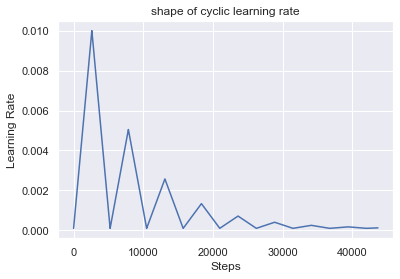

In [ ]:
step = np.arange(0, epoch * steps_per_epoch)
lr = cyclic_lr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("shape of cyclic learning rate")
plt.show()


In [ ]:
gru_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
history = gru_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch,
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100
438/438 [==============================] - 5s 9ms/step - loss: 0.0710 - val_loss: 0.0404
Epoch 2/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0418 - val_loss: 0.0418
Epoch 3/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0326 - val_loss: 0.0289
Epoch 4/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0270 - val_loss: 0.0216
Epoch 5/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0252 - val_loss: 0.0321
Epoch 6/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0250 - val_loss: 0.0186
Epoch 7/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0231 - val_loss: 0.0176
Epoch 8/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0212 - val_loss: 0.0208
Epoch 9/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0196 - val_loss: 0.0156
Epoch 10/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0186 - val_lo

109/109 [==============================] - 0s 3ms/step


---------------------------------------------------
GRU MAE for test set : 0.015
---------------------------------------------------



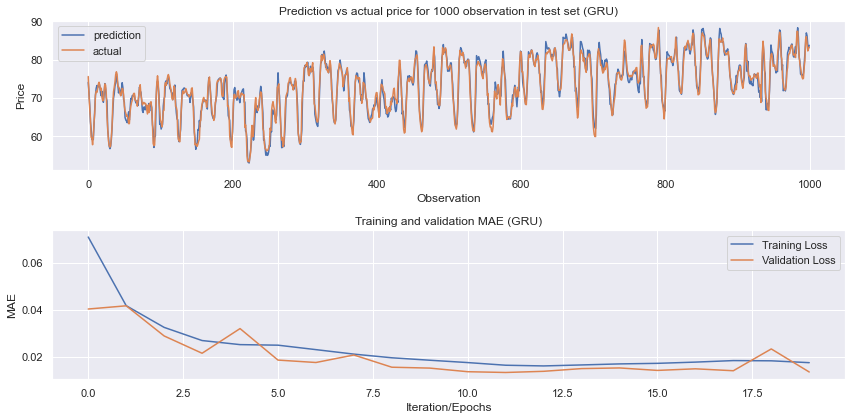

In [ ]:
y_pred = gru_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'GRU MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'GRU')

<h3> 2. LSTM </h3>

In [ ]:
def base_model_lstm():

    model = Sequential()
    model.add(LSTM(units = 32, return_sequences = True, activation="relu", input_shape = X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    return model

lstm_model = base_model_lstm()
lstm_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
lstm_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 24, 32)            6272      
                                                                 
 flatten_17 (Flatten)        (None, 768)               0         
                                                                 
 dense_34 (Dense)            (None, 128)               98432     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 129       
                                                                 
Total params: 104,833
Trainable params: 104,833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = lstm_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs =epoch,
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100
438/438 [==============================] - 6s 10ms/step - loss: 0.0807 - val_loss: 0.0727
Epoch 2/100
438/438 [==============================] - 4s 10ms/step - loss: 0.0416 - val_loss: 0.0334
Epoch 3/100
438/438 [==============================] - 4s 10ms/step - loss: 0.0316 - val_loss: 0.0235
Epoch 4/100
438/438 [==============================] - 4s 10ms/step - loss: 0.0274 - val_loss: 0.0225
Epoch 5/100
438/438 [==============================] - 4s 10ms/step - loss: 0.0254 - val_loss: 0.0209
Epoch 6/100
438/438 [==============================] - 4s 10ms/step - loss: 0.0247 - val_loss: 0.0190
Epoch 7/100
438/438 [==============================] - 4s 10ms/step - loss: 0.0240 - val_loss: 0.0192
Epoch 8/100
438/438 [==============================] - 4s 10ms/step - loss: 0.0230 - val_loss: 0.0192
Epoch 9/100
438/438 [==============================] - 4s 10ms/step - loss: 0.0228 - val_loss: 0.0185
Epoch 10/100
438/438 [==============================] - 4s 10ms/step - loss: 0.023

109/109 [==============================] - 1s 3ms/step


---------------------------------------------------
LSTM MAE for test set : 0.018
---------------------------------------------------



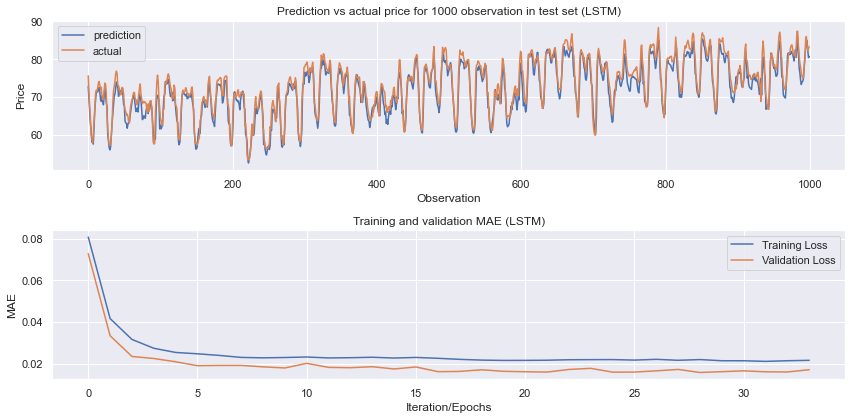

In [ ]:
y_pred = lstm_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'LSTM MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'LSTM')

<h3> 3. CNN </h3>

In [ ]:
def base_model_cnn():

    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    return model

cnn_model = base_model_cnn()
cnn_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
cnn_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 22, 32)            1568      
                                                                 
 flatten_18 (Flatten)        (None, 704)               0         
                                                                 
 dense_36 (Dense)            (None, 128)               90240     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 1)                 129       
                                                                 
Total params: 91,937
Trainable params: 91,937
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = cnn_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch,
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100
438/438 [==============================] - 2s 4ms/step - loss: 0.0636 - val_loss: 0.0425
Epoch 2/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0428 - val_loss: 0.0378
Epoch 3/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0377 - val_loss: 0.0308
Epoch 4/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0343 - val_loss: 0.0302
Epoch 5/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0315 - val_loss: 0.0250
Epoch 6/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0296 - val_loss: 0.0260
Epoch 7/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0282 - val_loss: 0.0252
Epoch 8/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0266 - val_loss: 0.0266
Epoch 9/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0255 - val_loss: 0.0249
Epoch 10/100
438/438 [==============================] - 1s 3ms/step - loss: 0.0249 - val_lo

109/109 [==============================] - 0s 1ms/step


---------------------------------------------------
CNN MAE for test set : 0.025
---------------------------------------------------



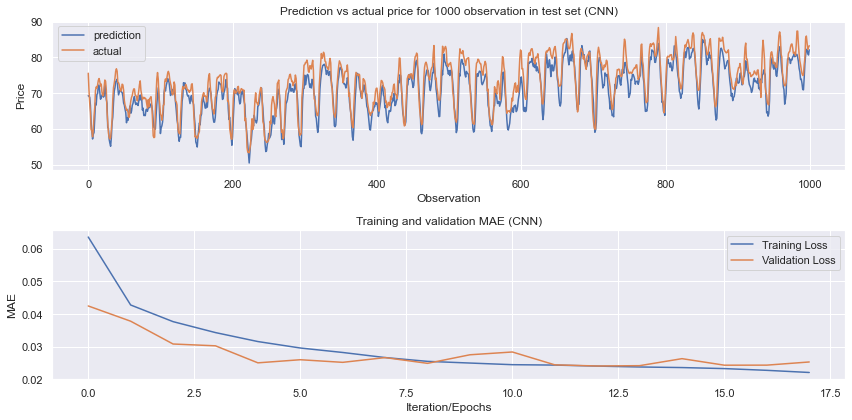

In [ ]:
y_pred = cnn_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'CNN MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'CNN')

<h3> 5. CNN-LSTM </h3>

In [ ]:
def base_model_cnn_lstm():

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X_train.shape[-2:]))
    model.add(LSTM(units = 8, return_sequences = True, activation="relu"))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1))

    return model

cnn_lstm_model = base_model_cnn_lstm()
cnn_lstm_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
cnn_lstm_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 22, 64)            3136      
                                                                 
 lstm_10 (LSTM)              (None, 22, 8)             2336      
                                                                 
 flatten_25 (Flatten)        (None, 176)               0         
                                                                 
 dense_50 (Dense)            (None, 256)               45312     
                                                                 
 dense_51 (Dense)            (None, 1)                 257       
                                                                 
Total params: 51,041
Trainable params: 51,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = cnn_lstm_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch,
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100
438/438 [==============================] - 5s 9ms/step - loss: 0.0584 - val_loss: 0.0615
Epoch 2/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0333 - val_loss: 0.0382
Epoch 3/100
438/438 [==============================] - 4s 8ms/step - loss: 0.0287 - val_loss: 0.0339
Epoch 4/100
438/438 [==============================] - 4s 8ms/step - loss: 0.0253 - val_loss: 0.0239
Epoch 5/100
438/438 [==============================] - 4s 8ms/step - loss: 0.0228 - val_loss: 0.0225
Epoch 6/100
438/438 [==============================] - 4s 8ms/step - loss: 0.0208 - val_loss: 0.0202
Epoch 7/100
438/438 [==============================] - 4s 8ms/step - loss: 0.0195 - val_loss: 0.0188
Epoch 8/100
438/438 [==============================] - 4s 8ms/step - loss: 0.0181 - val_loss: 0.0209
Epoch 9/100
438/438 [==============================] - 4s 8ms/step - loss: 0.0173 - val_loss: 0.0184
Epoch 10/100
438/438 [==============================] - 4s 8ms/step - loss: 0.0170 - val_lo

109/109 [==============================] - 0s 3ms/step


---------------------------------------------------
CNN-LSTM MAE for test set : 0.019
---------------------------------------------------



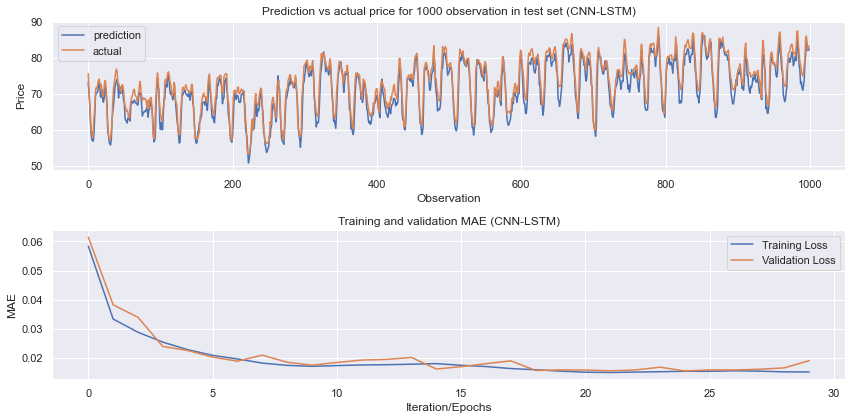

In [ ]:
y_pred = cnn_lstm_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'CNN-LSTM MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'CNN-LSTM')

<h3> 6. LSTM-Attention </h3>

In [ ]:
def LSTM_attention():
    inputs = Input(shape=(hist_size, X_train.shape[2]))
    #By masking the zeros, the model can learn to ignore the missing values and focus on the valid data.
    masked = Masking(mask_value=0.)(inputs)
    lstm = LSTM(132, return_sequences=True)(masked)
    attention = dot([lstm, lstm], axes=[2, 2])
    # extracting weight for every observation in the history size!
    attention = Dense(hist_size, activation='softmax')(attention)
    # assinging weight to lstm by dot product
    context = dot([attention, lstm], axes=[2, 1])
    flattened = Flatten()(context)8
    output = Dense(1)(flattened)
    model = Model(inputs=inputs, outputs=output)

    return model

LSTM_attention_model = LSTM_attention()
LSTM_attention_model.compile(optimizer=optimizer, loss='mae')
LSTM_attention_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 24, 16)]     0           []                               
                                                                                                  
 masking_3 (Masking)            (None, 24, 16)       0           ['input_4[0][0]']                
                                                                                                  
 lstm_9 (LSTM)                  (None, 24, 132)      78672       ['masking_3[0][0]']              
                                                                                                  
 dot_6 (Dot)                    (None, 24, 24)       0           ['lstm_9[0][0]',                 
                                                                  'lstm_9[0][0]']           

In [ ]:
history = LSTM_attention_model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

Epoch 1/100
438/438 [==============================] - 17s 32ms/step - loss: 0.0517 - val_loss: 0.0314
Epoch 2/100
438/438 [==============================] - 13s 29ms/step - loss: 0.0333 - val_loss: 0.0287
Epoch 3/100
438/438 [==============================] - 13s 29ms/step - loss: 0.0294 - val_loss: 0.0272
Epoch 4/100
438/438 [==============================] - 13s 30ms/step - loss: 0.0266 - val_loss: 0.0235
Epoch 5/100
438/438 [==============================] - 13s 30ms/step - loss: 0.0245 - val_loss: 0.0230
Epoch 6/100
438/438 [==============================] - 13s 30ms/step - loss: 0.0231 - val_loss: 0.0241
Epoch 7/100
438/438 [==============================] - 13s 29ms/step - loss: 0.0222 - val_loss: 0.0207
Epoch 8/100
438/438 [==============================] - 13s 29ms/step - loss: 0.0216 - val_loss: 0.0216
Epoch 9/100
438/438 [==============================] - 13s 30ms/step - loss: 0.0214 - val_loss: 0.0187
Epoch 10/100
438/438 [==============================] - 13s 29ms/step - l

109/109 [==============================] - 2s 9ms/step


---------------------------------------------------
LSTM-Attention MAE for test set : 0.015
---------------------------------------------------



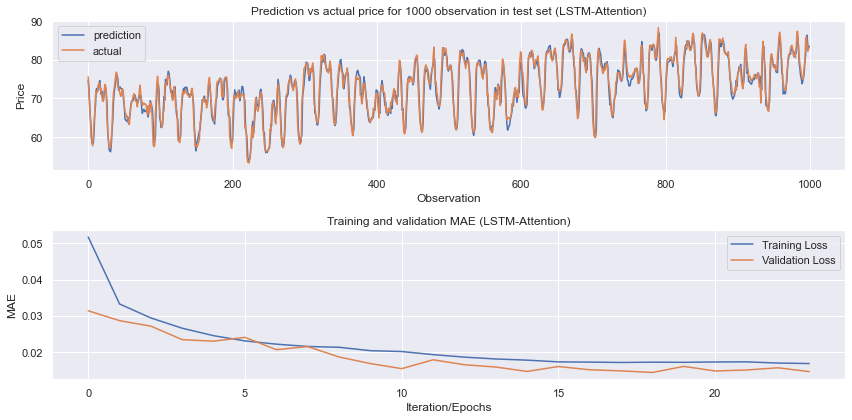

In [ ]:
y_pred = LSTM_attention_model.predict(X_test)
print('')
print('')

print('---------------------------------------------------')
print(f'LSTM-Attention MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'LSTM-Attention')

<h3> 7. Hybrid GRU-XGBoost </h3>

In [ ]:
def base_model_gru():

    model = Sequential()
    model.add(GRU(units=32, return_sequences=True, activation="relu", input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    return model

gru_model = base_model_gru()
gru_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')

print('')
print('GRU is fitting a model on train-validation sets...')
print('')

gru_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch,
                   batch_size = batch_size, callbacks=[callback])

print('')
print('----------------------------------')
print('GRU is predicting...')
print('')

residuals_train = y_train - gru_model.predict(X_train)
residuals_val   = y_val - gru_model.predict(X_val)

print('')
print('----------------------------------')
print('XGBoost is fitting a model on residuals...')
print('')

xgb_hybrid = xgb.XGBRegressor()
xgb_hybrid.fit(X_train_xgb, residuals_train,
               eval_set=[(X_train_xgb, residuals_train), (X_val_xgb, residuals_val)],
               eval_metric='mae',
               early_stopping_rounds=8,
               verbose=False)


y_train_pred = gru_model.predict(X_train) + xgb_hybrid.predict(X_train_xgb).reshape(-1,1)
y_val_pred   = gru_model.predict(X_val)   + xgb_hybrid.predict(X_val_xgb).reshape(-1,1)


GRU is fitting a model on train-validation sets...

Epoch 1/100
438/438 [==============================] - 5s 10ms/step - loss: 0.0701 - val_loss: 0.0486
Epoch 2/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0413 - val_loss: 0.0371
Epoch 3/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0322 - val_loss: 0.0235
Epoch 4/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0259 - val_loss: 0.0296
Epoch 5/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0241 - val_loss: 0.0236
Epoch 6/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0236 - val_loss: 0.0196
Epoch 7/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0226 - val_loss: 0.0174
Epoch 8/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0208 - val_loss: 0.0159
Epoch 9/100
438/438 [==============================] - 4s 9ms/step - loss: 0.0196 - val_loss: 0.0177
Epoch 10/100
438/438 [===============

109/109 [==============================] - 0s 3ms/step


---------------------------------------------------
GRU-XGBoost MAE for test set : 0.014
---------------------------------------------------



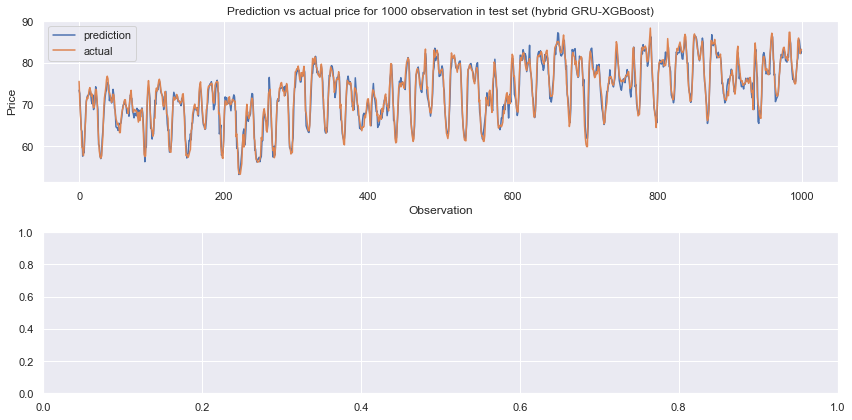

In [ ]:
y_test_pred  = gru_model.predict(X_test) + xgb_hybrid.predict(X_test_xgb).reshape(-1,1)
print('')
print('')

print('---------------------------------------------------')
print(f'GRU-XGBoost MAE for test set : {round(mean_absolute_error(y_test_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_test_pred)
print('')
plot_results(y_pred_actual, y_test_inv, 'hybrid' ,'hybrid GRU-XGBoost')


<h3> 8. Hybrid LSTM-Attention-XGBoost </h3>

In [ ]:
def LSTM_attention():
    inputs = Input(shape=(hist_size, X_train.shape[2]))
    #By masking the zeros, the model can learn to ignore the missing values and focus on the valid data.
    masked = Masking(mask_value=0.)(inputs)
    lstm = LSTM(132, return_sequences=True)(masked)
    attention = dot([lstm, lstm], axes=[2, 2])
    # extracting weight for every observation in the history size!
    attention = Dense(hist_size, activation='softmax')(attention)
    # assinging weight to lstm by dot product
    context = dot([attention, lstm], axes=[2, 1])
    flattened = Flatten()(context)
    output = Dense(1)(flattened)
    model = Model(inputs=inputs, outputs=output)

    return model

LSTM_attention_model = LSTM_attention()
LSTM_attention_model.compile(optimizer=optimizer, loss='mae')


print('')
print('LSTM-Attention is fitting a model on train-validation sets...')
print('')

LSTM_attention_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch,
                   batch_size = batch_size, callbacks=[callback])

print('')
print('----------------------------------')
print('LSTM-attention is predicting...')
print('')

residuals_train = y_train - LSTM_attention_model.predict(X_train)
residuals_val   = y_val - LSTM_attention_model.predict(X_val)

print('')
print('----------------------------------')
print('XGBoost is fitting a model on residuals...')
print('')

xgb_hybrid = xgb.XGBRegressor()
xgb_hybrid.fit(X_train_xgb, residuals_train,
               eval_set=[(X_train_xgb, residuals_train), (X_val_xgb, residuals_val)],
               eval_metric='mae',
               early_stopping_rounds=8,
               verbose=False)


y_train_pred = LSTM_attention_model.predict(X_train) + xgb_hybrid.predict(X_train_xgb).reshape(-1,1)
y_val_pred   = LSTM_attention_model.predict(X_val)   + xgb_hybrid.predict(X_val_xgb).reshape(-1,1)


LSTM-Attention is fitting a model on train-validation sets...

Epoch 1/100
438/438 [==============================] - 21s 37ms/step - loss: 0.0692 - val_loss: 0.0362
Epoch 2/100
438/438 [==============================] - 15s 35ms/step - loss: 0.0400 - val_loss: 0.0286
Epoch 3/100
438/438 [==============================] - 15s 34ms/step - loss: 0.0289 - val_loss: 0.0189
Epoch 4/100
438/438 [==============================] - 15s 34ms/step - loss: 0.0255 - val_loss: 0.0219
Epoch 5/100
438/438 [==============================] - 15s 34ms/step - loss: 0.0225 - val_loss: 0.0161
Epoch 6/100
438/438 [==============================] - 15s 34ms/step - loss: 0.0249 - val_loss: 0.0232
Epoch 7/100
438/438 [==============================] - 15s 34ms/step - loss: 0.0212 - val_loss: 0.0161
Epoch 8/100
438/438 [==============================] - 15s 34ms/step - loss: 0.0195 - val_loss: 0.0169
Epoch 9/100
438/438 [==============================] - 15s 34ms/step - loss: 0.0186 - val_loss: 0.0146
Epoch 10/

109/109 [==============================] - 1s 9ms/step


---------------------------------------------------
LSTM-Attention-XGBoost MAE for test set : 0.015
---------------------------------------------------



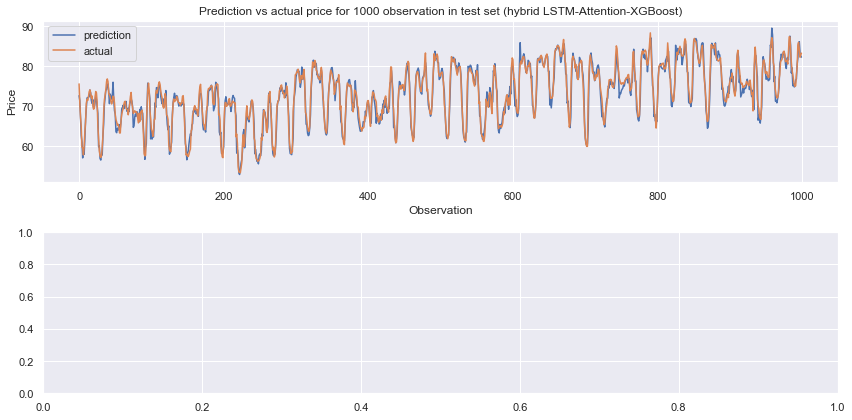

In [ ]:
y_test_pred  = LSTM_attention_model.predict(X_test) + xgb_hybrid.predict(X_test_xgb).reshape(-1,1)
print('')
print('')

print('---------------------------------------------------')
print(f'LSTM-Attention-XGBoost MAE for test set : {round(mean_absolute_error(y_test_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_test_pred)
print('')
plot_results(y_pred_actual, y_test_inv, 'hybrid' ,'hybrid LSTM-Attention-XGBoost')

<h3> Results </h3>
<p>
</p>
The MAE (Mean Absolute Error) is used to report the results for the normalized test set:
<p>
</p>    
<ul>    
<li> TSO prediction          : 0.070 </li>
<li> XGboost                 : 0.016 </li>
<li> GRU                     : 0.015 </li>
<li> LSTM                    : 0.018 </li>
<li> CNN                     : 0.025 </li>
<li> CNN-LSTM                : 0.019 </li>
<li> LSTM-Attention          : 0.015 </li>
<li> Hybrid GRU-XGBoost             : 0.014 </li>
<li> Hybrid LSTM-Attention-XGBoost  : 0.015 </li>    
</ul>

<strong> Note : </strong> According to the findings, the <strong> hybrid methods</strong> demonstrated better performance in terms of MAE compared to
other methods. It is worth mentioning that all machine learning/deep learning methods outperformed TSO prediction.